In [1]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import pickle
import glob
import os
import chainanalysis
import pandas as pd

In [2]:
all_simnames = []
all_unclustered_simnames = []
all_snaps = []
all_unclustered = []
all_snaps_data = []
all_unclustered_data = []
all_int_ext_ends = []
skip_first_cluster = False
path_name = './Stiff_Data/snap*'
snaps = ['./Stiff_Data/snap5000000', './Stiff_Data/snap10000000', './Stiff_Data/snap15000000',
         './Stiff_Data/snap20000000', './Stiff_Data/snap25000000', './Stiff_Data/snap30000000',
         './Stiff_Data/snap35000000', './Stiff_Data/snap40000000', './Stiff_Data/snap50000000',
         './Stiff_Data/snap60000000', './Stiff_Data/snap80000000', './Stiff_Data/snap100000000']
for n, snap in enumerate(snaps):
    with open(glob.glob(snap+'/*.pickle')[0],'rb') as f:
        int_ext_ends = pickle.load(f)
    all_int_ext_ends.append(int_ext_ends)
    if skip_first_cluster:
        simnames = sorted([cluster for cluster in glob.glob(snap+'/step_only/*cluster[1-9]*.data')])
    else:    
        simnames = sorted([cluster for cluster in glob.glob(snap+'/step_only/*cluster[1-9]*.data')])
        unclustered_simnames = sorted([cluster for cluster in glob.glob(snap+'/step_only/*cluster0*.data')])
    #print(simnames)
    all_simnames.append(simnames)
    all_unclustered_simnames.append(unclustered_simnames)
    clusters = []
    unclustered = []
    for simname in simnames:
        noext = os.path.splitext(simname)[0]
        #print(noext)
        reader = chainanalysis.BondReader(noext)
        reader.calc()
        clusters.append(reader)
    for simname in unclustered_simnames:
        noext = os.path.splitext(simname)[0]
        reader = chainanalysis.BondReader(noext)
        reader.calc()
        unclustered.append(reader)
    all_snaps.append(clusters)
    all_unclustered.append(unclustered)

In [3]:
# print(reader.params.keys())
# print(reader.frames[0].keys())
# print(reader.frames[0]['name'])
# print(reader.frames[0]['monoBcount'])
# print(reader.params['numB'])
#print(all_simnames)

In [4]:
def wrap(p):
    return (p + np.array([0.5, 0.5, 0.5])) % np.array([1,1,1]) - np.array([0.5, 0.5, 0.5])

## Manipulating Object Frames

In [5]:
#from full system at cluster step
steps_global = [5000000, 10000000, 15000000, 20000000, 25000000, 30000000, 35000000, 40000000, 50000000, 60000000, 80000000, 100000000]
p_global = [0.13055555555555556, 0.23555555555555555, 0.32722222222222225, 0.42319444444444443, 0.5438888888888889, 0.6243055555555556, 0.6847222222222222, 0.7326388888888888, 0.7925, 0.8276388888888889, 0.8752777777777778, 0.90125]
pAABB_global = [0.7351063829787234, 0.7576650943396226, 0.7610356536502547, 0.7761732851985559, 0.8051583248212462, 0.8184649610678532, 0.8273833671399595, 0.8314691943127962, 0.8354363827549947, 0.836717570062091, 0.8387813392573786, 0.8386500231160425]
n = np.linspace(0,50,51)

for snap_index,step in enumerate(steps_global):
    snap_data = []
    for cluster_index,cluster in enumerate(all_snaps[snap_index]):
        cnt = 0
        probs = [cluster.trajs['pAA'],cluster.trajs['pBB'],cluster.trajs['pAABB'],cluster.trajs['pAB']]
        PDI = cluster.trajs['PDI']
        extent = cluster.trajs['extent']
        numA = cluster.params['numA'] 
        numB = cluster.params['numB']
        numMonos = numA+numB
        if numA>numB:
            comp_frac = numA/numMonos
        else:
            comp_frac = numB/numMonos
        
        
        ChainDist = cluster.frames[-1]['chaindist']
        if not cluster.frames[-1]['blockAdist']:
            BlockADist = [[1,2,3],[0,0,0]]
        else:
            BlockADist = cluster.frames[-1]['blockAdist']
        if not cluster.frames[-1]['blockBdist']:
            BlockBDist = [[1,2,3],[0,0,0]]
        else:
            BlockBDist = cluster.frames[-1]['blockBdist']
        UnreactedMonoCount = (cluster.frames[-1]['monoAcount']+cluster.frames[-1]['monoBcount'])


        BlockDist = np.zeros(51)
        for id, val in enumerate(BlockADist[0]):
            BlockDist[val] += BlockADist[1][id]
        for id, val in enumerate(BlockBDist[0]):
            BlockDist[val] += BlockBDist[1][id]


        #Additional calculations
        TotalBlockXw = np.zeros((len(cluster.trajs['PDI'])))
        TotalBlockXn = np.zeros((len(cluster.trajs['PDI'])))
        BlockXw = np.zeros((len(cluster.trajs['PDI'])))
        BlockXn = np.zeros((len(cluster.trajs['PDI'])))
        Xn = np.zeros((len(cluster.trajs['PDI'])))
        for frame in cluster.frames[:]:
            BlockTotal = np.zeros((len(n)))
            if not frame['blockAdist']:
                pass
            else:
                for id, val in enumerate(frame['blockAdist'][0]):
                    BlockTotal[val] += frame['blockAdist'][1][id]
            if not frame['blockBdist']:
                pass
            else:
                for id, val in enumerate(frame['blockBdist'][0]):
                    BlockTotal[val] += frame['blockBdist'][1][id]
            if not frame['blockAdist']:
                pass
            else:
                BlockXw[cnt] = np.sum(np.array(frame['blockAdist'][0])*np.array(frame['blockAdist'][0])*np.array(frame['blockAdist'][1]))/np.sum(np.array(frame['blockAdist'][0])*np.array(frame['blockAdist'][1]))
                BlockXn[cnt] = np.sum(np.array(frame['blockAdist'][0])*np.array(frame['blockAdist'][1]))/np.sum(np.array(frame['blockAdist'][1]))
            Xn[cnt] = np.sum(np.array(frame['chaindist'][0])*np.array(frame['chaindist'][1]))/np.sum(np.array(frame['chaindist'][1]))
            TotalBlockXw[cnt] = np.sum(n*n*BlockTotal)/np.sum(n*BlockTotal) 
            TotalBlockXn[cnt] = np.sum(n*BlockTotal)/np.sum(BlockTotal)
            cnt+=1
        DOP = Xn
        BlockDOP = BlockXn
        if BlockDOP != 0:
            BlockPDI = BlockXw/BlockXn
        else:
            BlockPDI = 0
        TotalBlockDOP = TotalBlockXn
        TotalBlockPDI = TotalBlockXw/TotalBlockXn
        
        #cluster size metrics
        LongestChain = len(ChainDist[0])
        for block_index in reversed(range(len(BlockDist))):
            if BlockDist[block_index] > 0:
                LongestBlock = block_index
                break

        #getting cluster coordinates for Rg calculation
        box_size = 50.0
        coords = []
        numheaderlines = 9
        files = sorted([cluster_name for cluster_name in glob.glob(snaps[snap_index]+'/step_only/*cluster[1-9]*.data')])
        filename = os.path.splitext(files[cluster_index])[0]
        inputfile = open(filename+'.lammpstrj','r')
        tempfile = open('temp.csv','w')
        inputlines = inputfile.readlines()
        try:
            tempfile.write('atomid,type,x,y,z\n')
            for line in inputlines[numheaderlines:]:
                split = str.split(line)
                tempfile.write(split[0]+','+split[1]+','+str(box_size*float(split[2]))+','+str(box_size*float(split[3]))+','+str(box_size*float(split[4]))+'\n')
        finally:
            inputfile.close()
            tempfile.close()
        df = pd.read_csv('temp.csv')
        df = df.sort_values(by=['atomid'])
        df.to_csv('temp.csv', index=False)
        X = df.values
        coords.append(X[1::3,2:])
        X = X[1::3,2:]
                

        
#         CoM = np.array([np.sum(X[:,0])/len(X[:,0]),np.sum(X[:,1])/len(X[:,0]),np.sum(X[:,2])/len(X[:,0])])
#         print('First:{}'.format(CoM))
#         X_wrap = ((np.copy(X)-CoM)/box_size)+np.array([0.25,0.25,0.25])
#         for i in range(len(X)):
#             if X_wrap[i,0] > 0.5 or X_wrap[i,2] > 0.5 or X_wrap[i,2] > 0.5:
#                 X_wrap[i,:] = box_size*wrap(X[i,:])
#             else:
#                 X_wrap[i,:] = box_size*(X[i,:])
#         X=X_wrap
        
        #Rg calculation
        CoM = np.array([np.sum(X[:,0])/len(X[:,0]),np.sum(X[:,1])/len(X[:,0]),np.sum(X[:,2])/len(X[:,0])])
        Rg = ((np.sum((X-CoM)**2))**(0.5))/len(X[:,0])

        os.remove('temp.csv')
        
        with open(filename+".lammpstrj.ordertraj.txt",'r') as orderfile:
            for line_cnt,line in enumerate(orderfile):
                if line_cnt == 0:
                    split = str.split(line)
                    order = float(split[1])
        
        #sequences
        full_seqs = cluster.frames[-1]['numseq']
        cluster_set = set([atomid for chain in cluster.frames[-1]['numseq'] for atomid in chain if len(chain)>3])
        seq_set = [set(chain) for chain in full_seqs if len(chain)>3]
        
        cluster_data = [probs, PDI, BlockPDI, extent, ChainDist, BlockADist, BlockBDist, TotalBlockDOP,
                        TotalBlockPDI, UnreactedMonoCount, DOP, BlockDOP, LongestChain,LongestBlock,Rg,
                        cluster_set,full_seqs,seq_set,comp_frac,order]
        snap_data.append(cluster_data)
    all_snaps_data.append(snap_data)
        
        

Repeat for unclustered.

In [6]:
for snap_index,step in enumerate(steps_global):
    snap_data = []
    for cluster_index,cluster in enumerate(all_unclustered[snap_index]):
        cnt = 0
        probs = [cluster.trajs['pAA'],cluster.trajs['pBB'],cluster.trajs['pAABB'],cluster.trajs['pAB']]
        PDI = cluster.trajs['PDI']
        extent = cluster.trajs['extent']
        numA = cluster.params['numA'] 
        numB = cluster.params['numB']
        numMonos = numA+numB
        if numA>numB:
            comp_frac = numA/numMonos
        else:
            comp_frac = numB/numMonos
        
        
        ChainDist = cluster.frames[-1]['chaindist']
        if not cluster.frames[-1]['blockAdist']:
            BlockADist = [[1,2,3],[0,0,0]]
        else:
            BlockADist = cluster.frames[-1]['blockAdist']
        if not cluster.frames[-1]['blockBdist']:
            BlockBDist = [[1,2,3],[0,0,0]]
        else:
            BlockBDist = cluster.frames[-1]['blockBdist']
        UnreactedMonoCount = (cluster.frames[-1]['monoAcount']+cluster.frames[-1]['monoBcount'])


        BlockDist = np.zeros(101)
        for id, val in enumerate(BlockADist[0]):
            BlockDist[val] += BlockADist[1][id]
        for id, val in enumerate(BlockBDist[0]):
            BlockDist[val] += BlockBDist[1][id]


        #Additional calculations
        TotalBlockXw = np.zeros((len(cluster.trajs['PDI'])))
        TotalBlockXn = np.zeros((len(cluster.trajs['PDI'])))
        BlockXw = np.zeros((len(cluster.trajs['PDI'])))
        BlockXn = np.zeros((len(cluster.trajs['PDI'])))
        Xn = np.zeros((len(cluster.trajs['PDI'])))
        for frame in cluster.frames[:]:
            BlockTotal = np.zeros((len(n)))
            if not frame['blockAdist']:
                pass
            else:
                for id, val in enumerate(frame['blockAdist'][0]):
                    BlockTotal[val] += frame['blockAdist'][1][id]
            if not frame['blockBdist']:
                pass
            else:
                for id, val in enumerate(frame['blockBdist'][0]):
                    BlockTotal[val] += frame['blockBdist'][1][id]
            if not frame['blockAdist']:
                pass
            else:
                BlockXw[cnt] = np.sum(np.array(frame['blockAdist'][0])*np.array(frame['blockAdist'][0])*np.array(frame['blockAdist'][1]))/np.sum(np.array(frame['blockAdist'][0])*np.array(frame['blockAdist'][1]))
                BlockXn[cnt] = np.sum(np.array(frame['blockAdist'][0])*np.array(frame['blockAdist'][1]))/np.sum(np.array(frame['blockAdist'][1]))
            Xn[cnt] = np.sum(np.array(frame['chaindist'][0])*np.array(frame['chaindist'][1]))/np.sum(np.array(frame['chaindist'][1]))
            TotalBlockXw[cnt] = np.sum(n*n*BlockTotal)/np.sum(n*BlockTotal) 
            TotalBlockXn[cnt] = np.sum(n*BlockTotal)/np.sum(BlockTotal)
            cnt+=1
        DOP = Xn
        BlockDOP = BlockXn
        if BlockDOP != 0:
            BlockPDI = BlockXw/BlockXn
        else:
            BlockPDI = 0
        TotalBlockDOP = TotalBlockXn
        TotalBlockPDI = TotalBlockXw/TotalBlockXn
        
        #cluster size metrics
        LongestChain = len(ChainDist[0])
        for block_index in reversed(range(len(BlockDist))):
            if BlockDist[block_index] > 0:
                LongestBlock = block_index
                break

        #getting cluster coordinates for Rg calculation
        box_size = 50.0
        coords = []
        numheaderlines = 9
        files = sorted([cluster_name for cluster_name in glob.glob(snaps[snap_index]+'/step_only/*cluster[1-9]*.data')])
        filename = os.path.splitext(files[cluster_index])[0]
        inputfile = open(filename+'.lammpstrj','r')
        tempfile = open('temp.csv','w')
        inputlines = inputfile.readlines()
        try:
            tempfile.write('atomid,type,x,y,z\n')
            for line in inputlines[numheaderlines:]:
                split = str.split(line)
                tempfile.write(split[0]+','+split[1]+','+str(box_size*float(split[2]))+','+str(box_size*float(split[3]))+','+str(box_size*float(split[4]))+'\n')
        finally:
            inputfile.close()
            tempfile.close()
        df = pd.read_csv('temp.csv')
        df = df.sort_values(by=['atomid'])
        df.to_csv('temp.csv', index=False)
        X = df.values
        coords.append(X[1::3,2:])
        X = X[1::3,2:]
                

        
#         CoM = np.array([np.sum(X[:,0])/len(X[:,0]),np.sum(X[:,1])/len(X[:,0]),np.sum(X[:,2])/len(X[:,0])])
#         print('First:{}'.format(CoM))
#         X_wrap = ((np.copy(X)-CoM)/box_size)+np.array([0.25,0.25,0.25])
#         for i in range(len(X)):
#             if X_wrap[i,0] > 0.5 or X_wrap[i,2] > 0.5 or X_wrap[i,2] > 0.5:
#                 X_wrap[i,:] = box_size*wrap(X[i,:])
#             else:
#                 X_wrap[i,:] = box_size*(X[i,:])
#         X=X_wrap
        
        #Rg calculation
        CoM = np.array([np.sum(X[:,0])/len(X[:,0]),np.sum(X[:,1])/len(X[:,0]),np.sum(X[:,2])/len(X[:,0])])
        Rg = ((np.sum((X-CoM)**2))**(0.5))/len(X[:,0])

        os.remove('temp.csv')
        
        with open(filename+".lammpstrj.ordertraj.txt",'r') as orderfile:
            for line_cnt,line in enumerate(orderfile):
                if line_cnt == 0:
                    split = str.split(line)
                    order = float(split[1])
        
        #sequences
        full_seqs = cluster.frames[-1]['numseq']
        cluster_set = set([atomid for chain in cluster.frames[-1]['numseq'] for atomid in chain if len(chain)>3])
        seq_set = [set(chain) for chain in full_seqs if len(chain)>3]
        
        cluster_data = [probs, PDI, BlockPDI, extent, ChainDist, BlockADist, BlockBDist, TotalBlockDOP,
                        TotalBlockPDI, UnreactedMonoCount, DOP, BlockDOP, LongestChain,LongestBlock,Rg,
                        cluster_set,full_seqs,seq_set,comp_frac,order]
        snap_data.append(cluster_data)
    all_unclustered_data.append(snap_data)

In [7]:
# print(files)
# print(filename)

## In-cluster Bonding

In [8]:
for time_index,snap_data in enumerate(all_snaps_data):
    if time_index > 1:
        #shorthand for old and new timestep snapshots
        t1 = time_index - 1
        t2 = time_index
        
        all_cluster_t1_set = set()
        #group set of all clustered atomids at t1
        for cluster_data in all_snaps_data[t1]:
            all_cluster_t1_set = all_cluster_t1_set | cluster_data[15]
        
        for cluster_t1_id, cluster_t1_data in enumerate(all_snaps_data[t1]):
            #establish group set of "all other clusters at t1"
            all_other_cluster_t1_set = all_cluster_t1_set - cluster_t1_data[15]
            #Decision list for whether to compare sequences in clusters at each timestep
            compare_clusters = [False for cluster in all_snaps_data[t2]]
            cluster_self_bonding = []
            cluster_merge_bonding = []
            cluster_new_bonding = []
            #Check for any overlap in atomids in each cluster at new time
            for cluster_t2_id,cluster_t2_data in enumerate(all_snaps_data[t2]):
                self_bonding = []
                merge_bonding = []
                new_bonding = []
                #check intersection of sets at next time
                if len(cluster_t1_data[15]&cluster_t2_data[15]) != 0:
                    compare_clusters[cluster_t2_id] = True
                    #Compare sequences for overlap
                    for old_sequence in cluster_t1_data[17]:
                        for new_sequence in cluster_t2_data[17]:
                            #when sequences do overlap check where the new portions are from
                            if old_sequence.issubset(new_sequence):
                                change = new_sequence - old_sequence
                                #Oligomer filter
                                if len(change)>9 or len(old_sequence)>9:
                                    #if the new portions were part of chains from the old cluster
                                    if len(change&cluster_t1_data[15]) > 0:
                                        self_bonding.append(change)
                                    #if the new portions were part of other clusters at previous time (t1)
                                    elif len(change&all_other_cluster_t1_set) > 0:
                                        merge_bonding.append(change)
                                    #if the new portions were not part of clusters at previous time (t1)
                                    elif len(change) > 0 and len(change&all_cluster_t1_set)==0:
                                        new_bonding.append(change)
                                
                cluster_self_bonding.append(self_bonding)
                cluster_merge_bonding.append(merge_bonding)
                cluster_new_bonding.append(new_bonding)
            cluster_bonding = [cluster_self_bonding,cluster_merge_bonding,cluster_new_bonding,cluster_self_bonding+cluster_merge_bonding+cluster_new_bonding]    
            all_snaps_data[t1][cluster_t1_id].append(cluster_bonding)


Repeat for unclustered

In [9]:
for time_index,snap_data in enumerate(all_unclustered_data):
    if time_index > 1:
        #shorthand for old and new timestep snapshots
        t1 = time_index - 1
        t2 = time_index
        
        all_cluster_t1_set = set()
        #group set of all clustered atomids at t1
        for cluster_data in all_unclustered_data[t1]:
            all_cluster_t1_set = all_cluster_t1_set | cluster_data[15]
        
        for cluster_t1_id, cluster_t1_data in enumerate(all_unclustered_data[t1]):
            #establish group set of "all other clusters at t1"
            all_other_cluster_t1_set = all_cluster_t1_set - cluster_t1_data[15]
            #Decision list for whether to compare sequences in clusters at each timestep
            compare_clusters = [False for cluster in all_snaps_data[t2]]
            cluster_self_bonding = []
            cluster_merge_bonding = []
            cluster_new_bonding = []
            #Check for any overlap in atomids in each cluster at new time
            for cluster_t2_id,cluster_t2_data in enumerate(all_unclustered_data[t2]):
                self_bonding = []
                merge_bonding = []
                new_bonding = []
                #check intersection of sets at next time
                if len(cluster_t1_data[15]&cluster_t2_data[15]) != 0:
                    compare_clusters[cluster_t2_id] = True
                    #Compare sequences for overlap
                    for old_sequence in cluster_t1_data[17]:
                        for new_sequence in cluster_t2_data[17]:
                            #when sequences do overlap check where the new portions are from
                            if old_sequence.issubset(new_sequence):
                                change = new_sequence - old_sequence
                                #Oligomer filter
                                if len(change)>9 or len(old_sequence)>9:
                                    #if the new portions were part of chains from the old cluster
                                    if len(change&cluster_t1_data[15]) > 0:
                                        self_bonding.append(change)
                                    #if the new portions were part of other clusters at previous time (t1)
                                    elif len(change&all_other_cluster_t1_set) > 0:
                                        merge_bonding.append(change)
                                    #if the new portions were not part of clusters at previous time (t1)
                                    elif len(change) > 0 and len(change&all_cluster_t1_set)==0:
                                        new_bonding.append(change)
                                
                cluster_self_bonding.append(self_bonding)
                cluster_merge_bonding.append(merge_bonding)
                cluster_new_bonding.append(new_bonding)
            cluster_bonding = [cluster_self_bonding,cluster_merge_bonding,cluster_new_bonding,cluster_self_bonding+cluster_merge_bonding+cluster_new_bonding]    
            all_unclustered_data[t1][cluster_t1_id].append(cluster_bonding)


## Plotting

In [10]:
# #Colormaps
# def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
#     new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
#         'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
#         cmap(np.linspace(minval, maxval, n)))
#     return new_cmap


steps_global_cb = ((10**(-6))*np.array([5000000, 10000000, 15000000, 20000000, 25000000, 30000000, 35000000, 40000000, 50000000, 60000000, 80000000, 100000000])).tolist()


#Colormaps for timestep
c_id = (np.array(steps_global_cb)-np.min(np.array(steps_global_cb)))/(np.max(np.array(steps_global_cb))-np.min(np.array(steps_global_cb)))
cmap = plt.cm.viridis
norm = matplotlib.colors.Normalize(vmin=np.min(np.array(steps_global_cb)),vmax=np.max(np.array(steps_global_cb)))
sm = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
sm.set_array([])

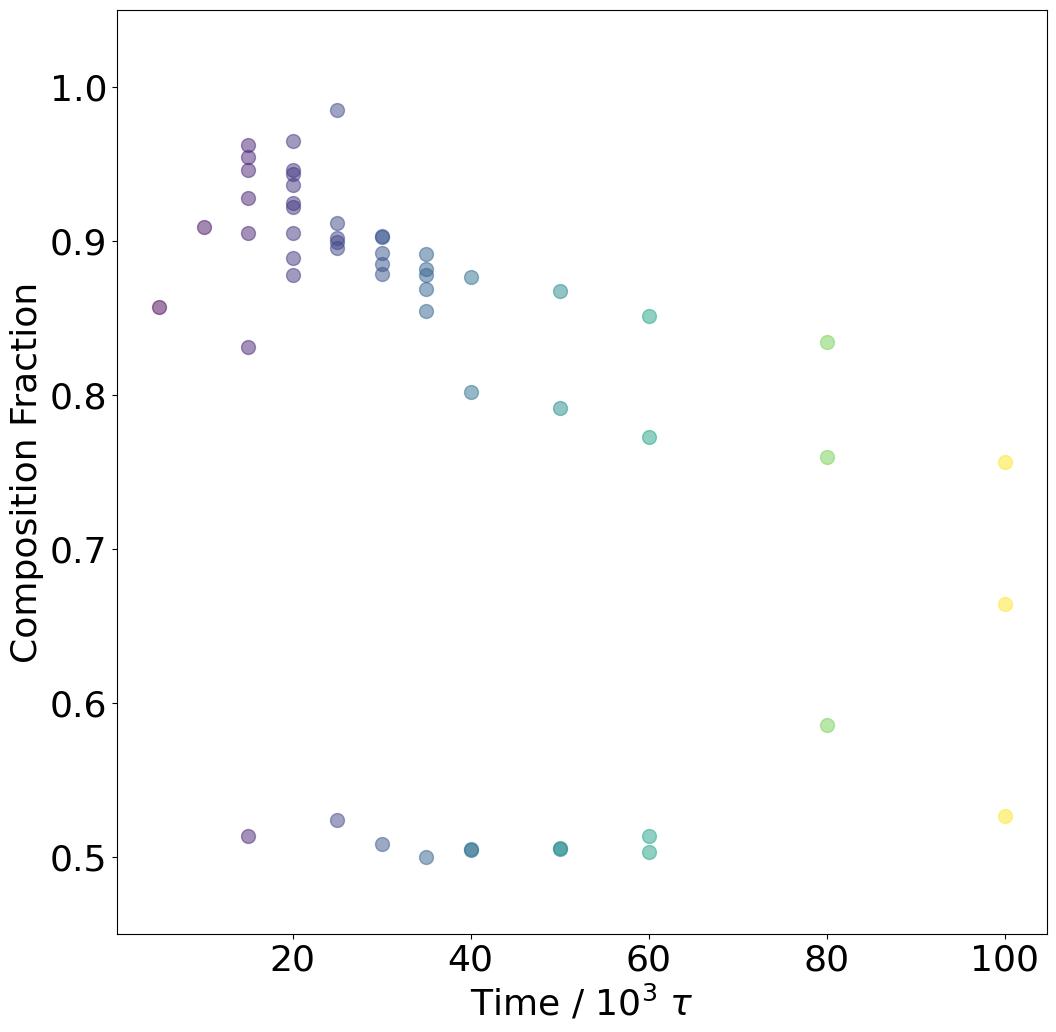

In [11]:
fig, host = plt.subplots(1,1,figsize = (12,12))

for time_index,snap_data in enumerate(all_snaps_data):
    for cluster_index,cluster_data in enumerate(snap_data):

        host.scatter((10**(-6))*steps_global[time_index],cluster_data[18],100,color=cmap(c_id[time_index]),marker='o',alpha=0.5)

#         if time_index < 4 and cluster_data[18] < 0.8:
#             print('Step: {}'.format(steps_global[time_index]))
#             print('Cluster: {}'.format(all_simnames[time_index][cluster_index]))
#             print('Frac: {}'.format(cluster_data[18]))

        
host.tick_params(axis='both', which='major', labelsize=26)


host.set_xlabel(r"Time / $10^3 \ \tau$",size=26)
host.set_ylabel(r"Composition Fraction",size=26)
host.set_ylim(0.45, 1.05);
#host.set_xlim(-13.05, -7.05);

#host.legend(handles = [patch1,patch2,patch3],fontsize=26)

#fig.savefig('copoly3_cluster_dominant_species_fraction.png',dpi=300, bbox_inches='tight')

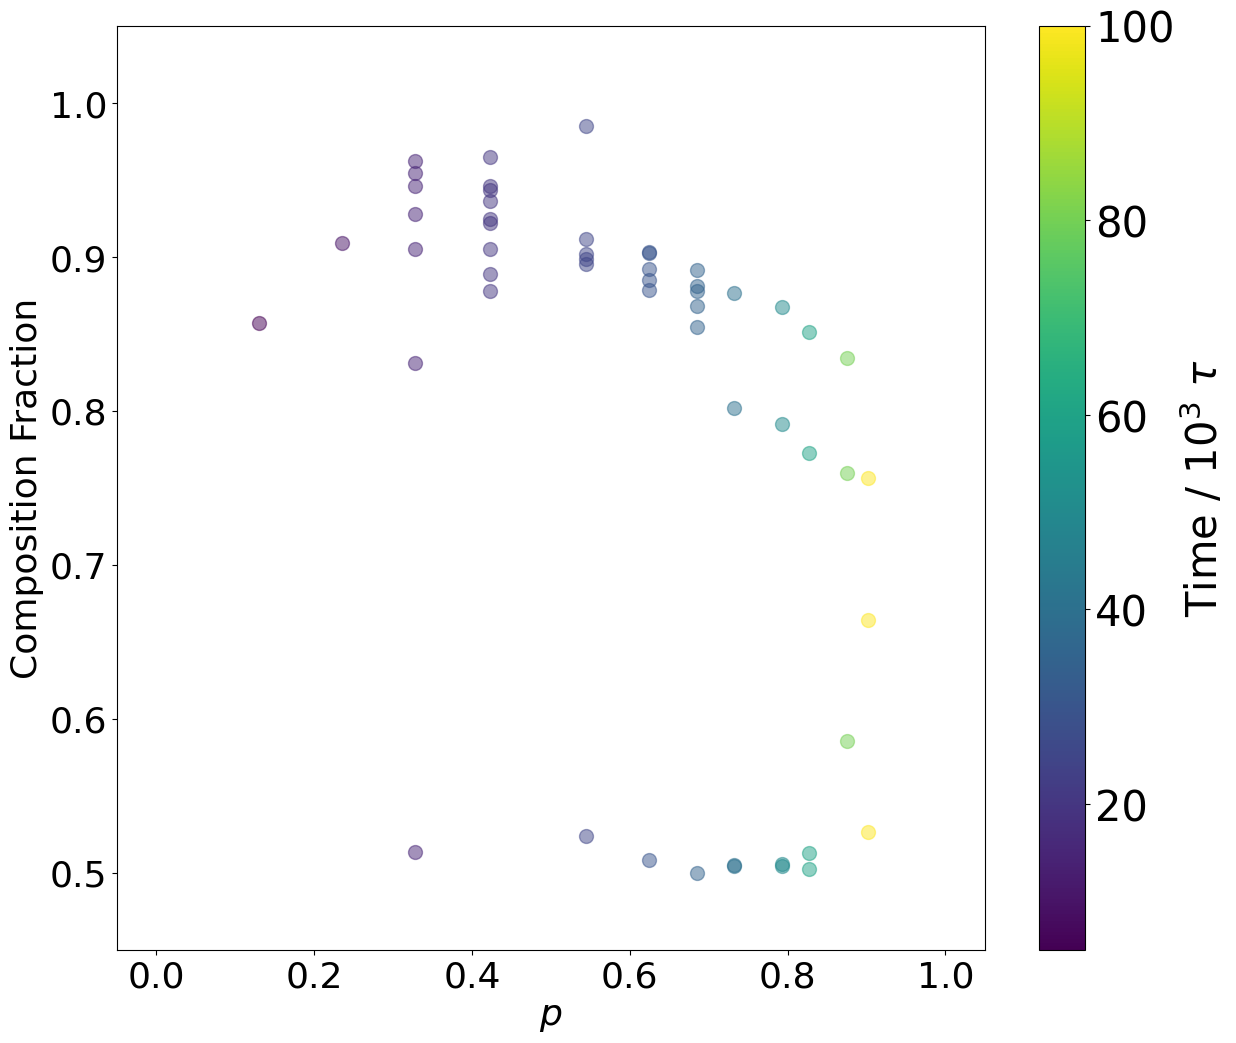

In [12]:
fig, host = plt.subplots(1,1,figsize = (14,12))

for time_index,snap_data in enumerate(all_snaps_data):
    for cluster_index,cluster_data in enumerate(snap_data):
        host.scatter(p_global[time_index],cluster_data[18],100,color=cmap(c_id[time_index]),marker='o',alpha=0.5)


        
host.tick_params(axis='both', which='major', labelsize=26)


cbar = plt.colorbar(sm,ax=host)#,label=r'$\frac{\tau_D}{\tau_R}$');
#cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(label=r"Time / $10^3 \ \tau$",size=30)
cbar.ax.tick_params(labelsize=30)
cbar.ax.yaxis.offsetText.set_fontsize(30)
#cbar.ax.set_yticklabels('')

host.set_xlabel(r"$p$",size=26)
host.set_ylabel(r"Composition Fraction",size=26)
host.set_ylim(0.45, 1.05);
host.set_xlim(-0.05, 1.05);

#host.legend(handles = [patch1,patch2,patch3],fontsize=26)

#fig.savefig('copoly3_cluster_dominant_species_fraction.png',dpi=300, bbox_inches='tight')

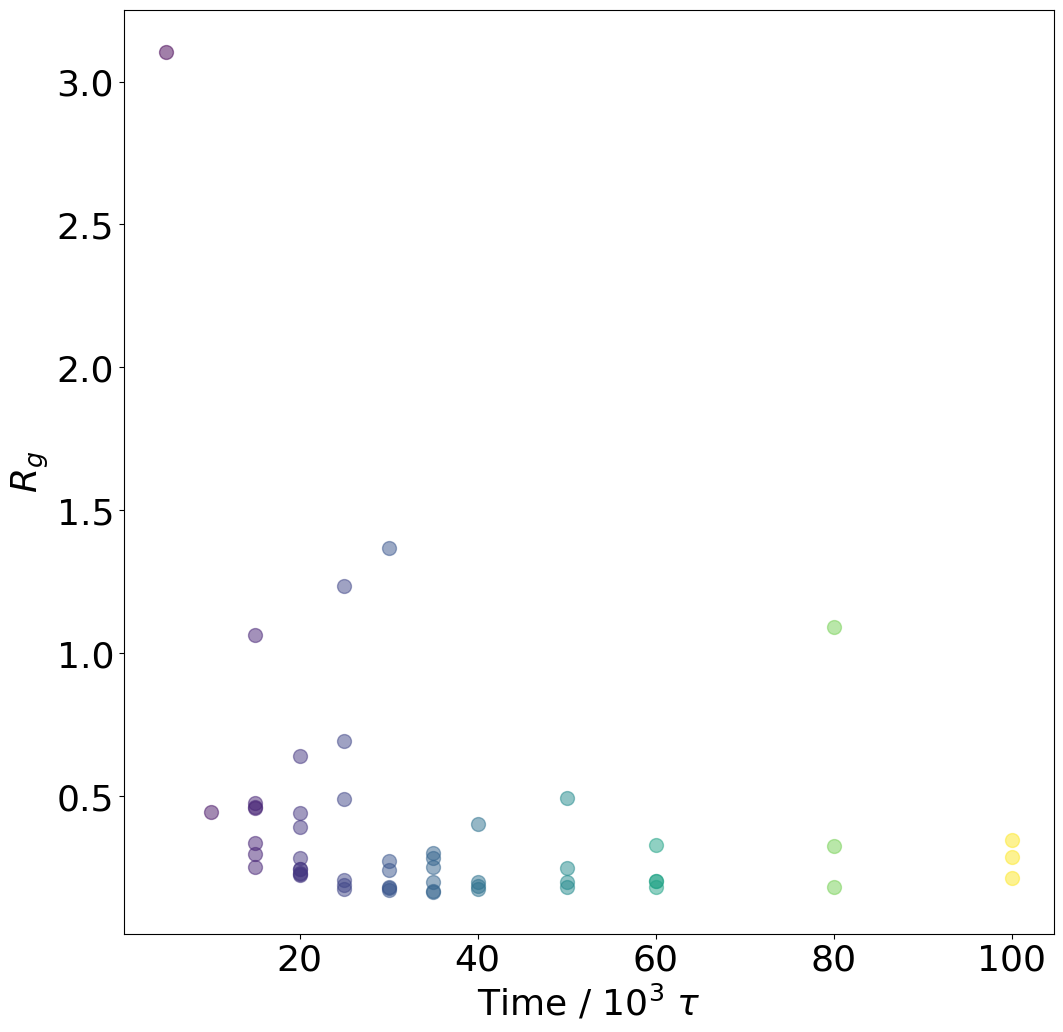

In [13]:
fig, host = plt.subplots(1,1,figsize = (12,12))

for time_index,snap_data in enumerate(all_snaps_data):
    for cluster_index,cluster_data in enumerate(snap_data):
        host.scatter((10**(-6))*steps_global[time_index],cluster_data[14],100,color=cmap(c_id[time_index]),marker='o',alpha=0.5)



host.tick_params(axis='both', which='major', labelsize=26)


host.set_xlabel(r"Time / $10^3 \ \tau$",size=26)
host.set_ylabel(r"$R_g$",size=26);
#host.set_ylim(-0.05, 1.05);
#host.set_xlim(-13.05, -7.05);

#host.legend(handles = [patch1,patch2,patch3],fontsize=26)

#fig.savefig('copoly3_cluster_dominant_species_fraction.png',dpi=300, bbox_inches='tight')

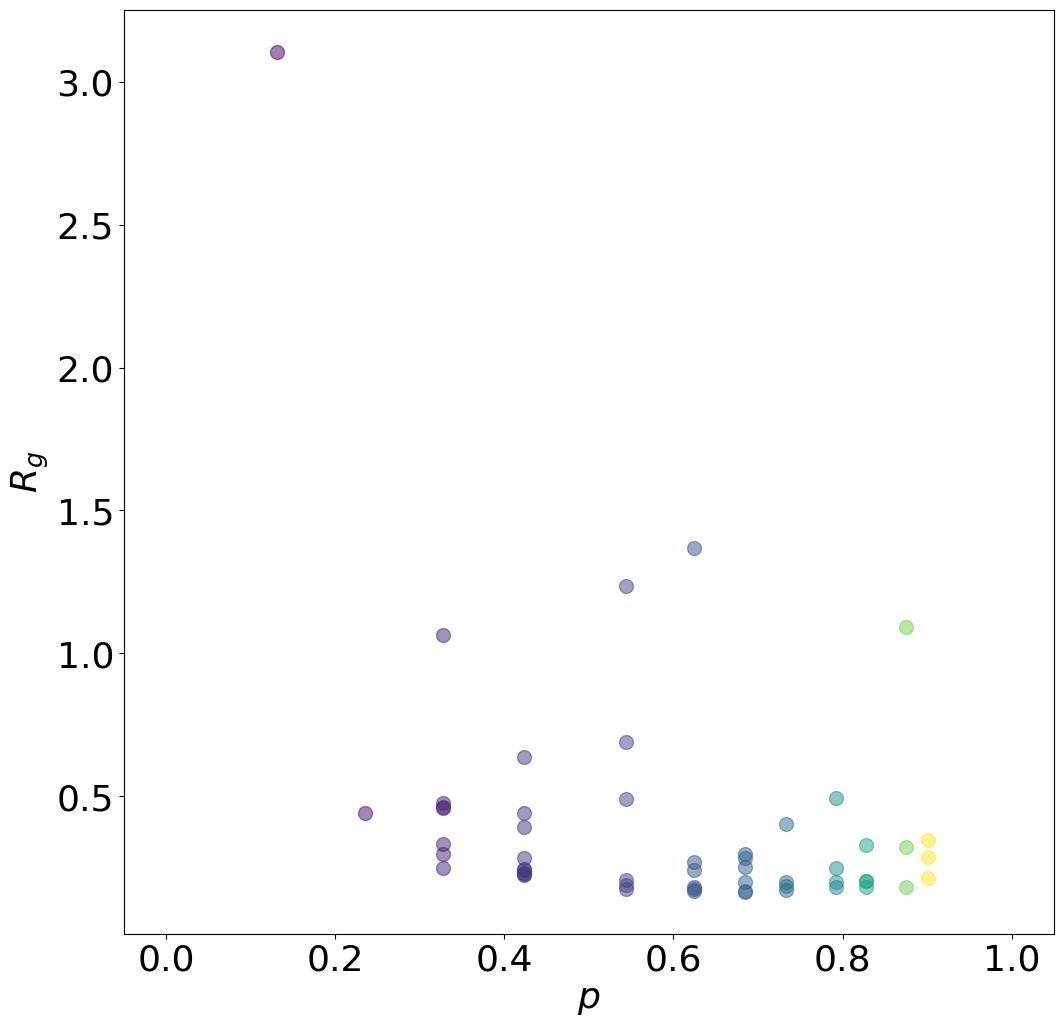

In [14]:
fig, host = plt.subplots(1,1,figsize = (12,12))

for time_index,snap_data in enumerate(all_snaps_data):
    for cluster_index,cluster_data in enumerate(snap_data):
        host.scatter(p_global[time_index],cluster_data[14],100,color=cmap(c_id[time_index]),marker='o',alpha=0.5)

        
host.tick_params(axis='both', which='major', labelsize=26)


host.set_xlabel(r"$p$",size=26)
host.set_ylabel(r"$R_g$",size=26)
#host.set_ylim(-0.05, 1.05);
host.set_xlim(-0.05, 1.05);

#host.legend(handles = [patch1,patch2,patch3],fontsize=26)

#fig.savefig('copoly3_cluster_dominant_species_fraction.png',dpi=300, bbox_inches='tight')

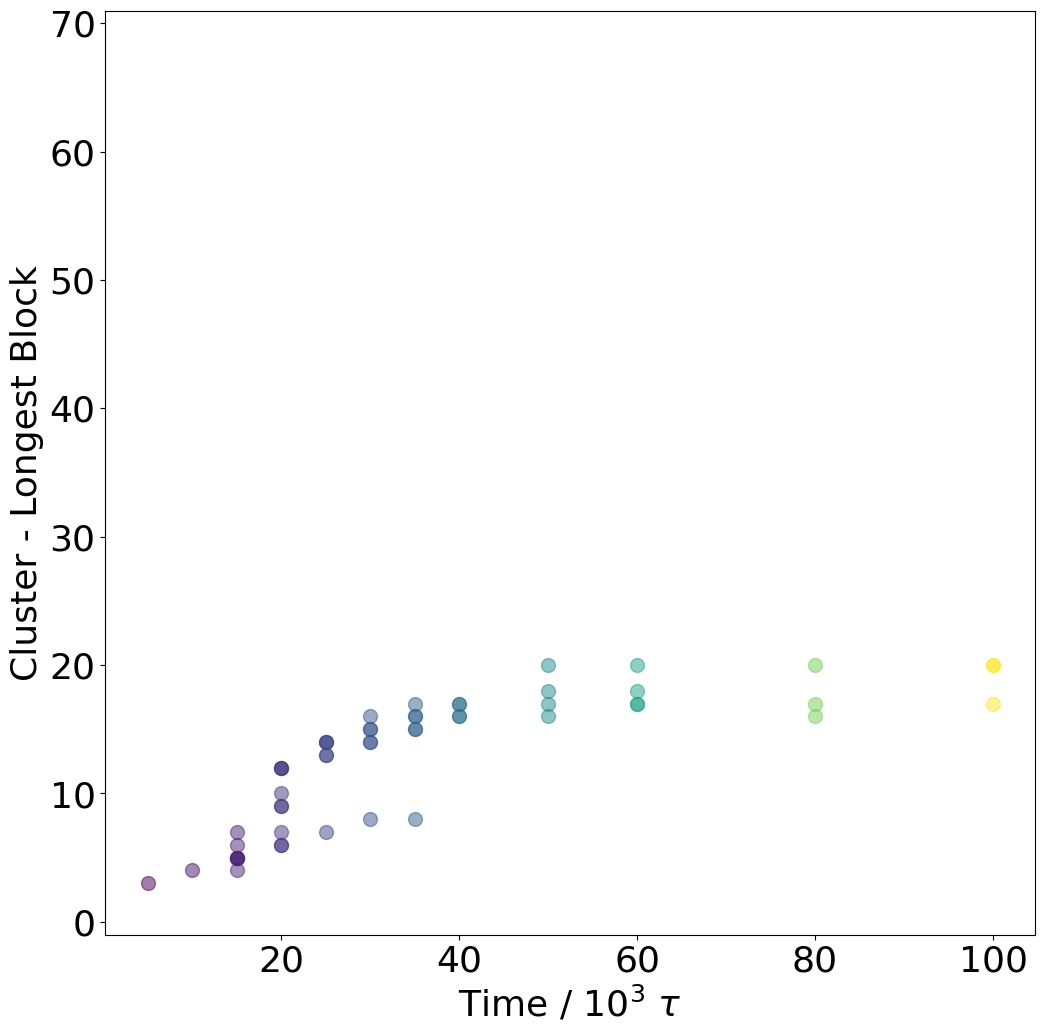

In [15]:
fig, host = plt.subplots(1,1,figsize = (12,12))

for time_index,snap_data in enumerate(all_snaps_data):
    for cluster_index,cluster_data in enumerate(snap_data):
        host.scatter((10**(-6))*steps_global[time_index],cluster_data[13],100,color=cmap(c_id[time_index]),marker='o',alpha=0.5)



host.tick_params(axis='both', which='major', labelsize=26)


host.set_xlabel(r"Time / $10^3 \ \tau$",size=26)
host.set_ylabel(r"Cluster - Longest Block",size=26);
host.set_yticks([0,10,20,30,40,50,60,70]);
host.set_ylim(-1, 71);

#host.legend(handles = [patch1,patch2,patch3],fontsize=26)

#fig.savefig('copoly3_cluster_dominant_species_fraction.png',dpi=300, bbox_inches='tight')

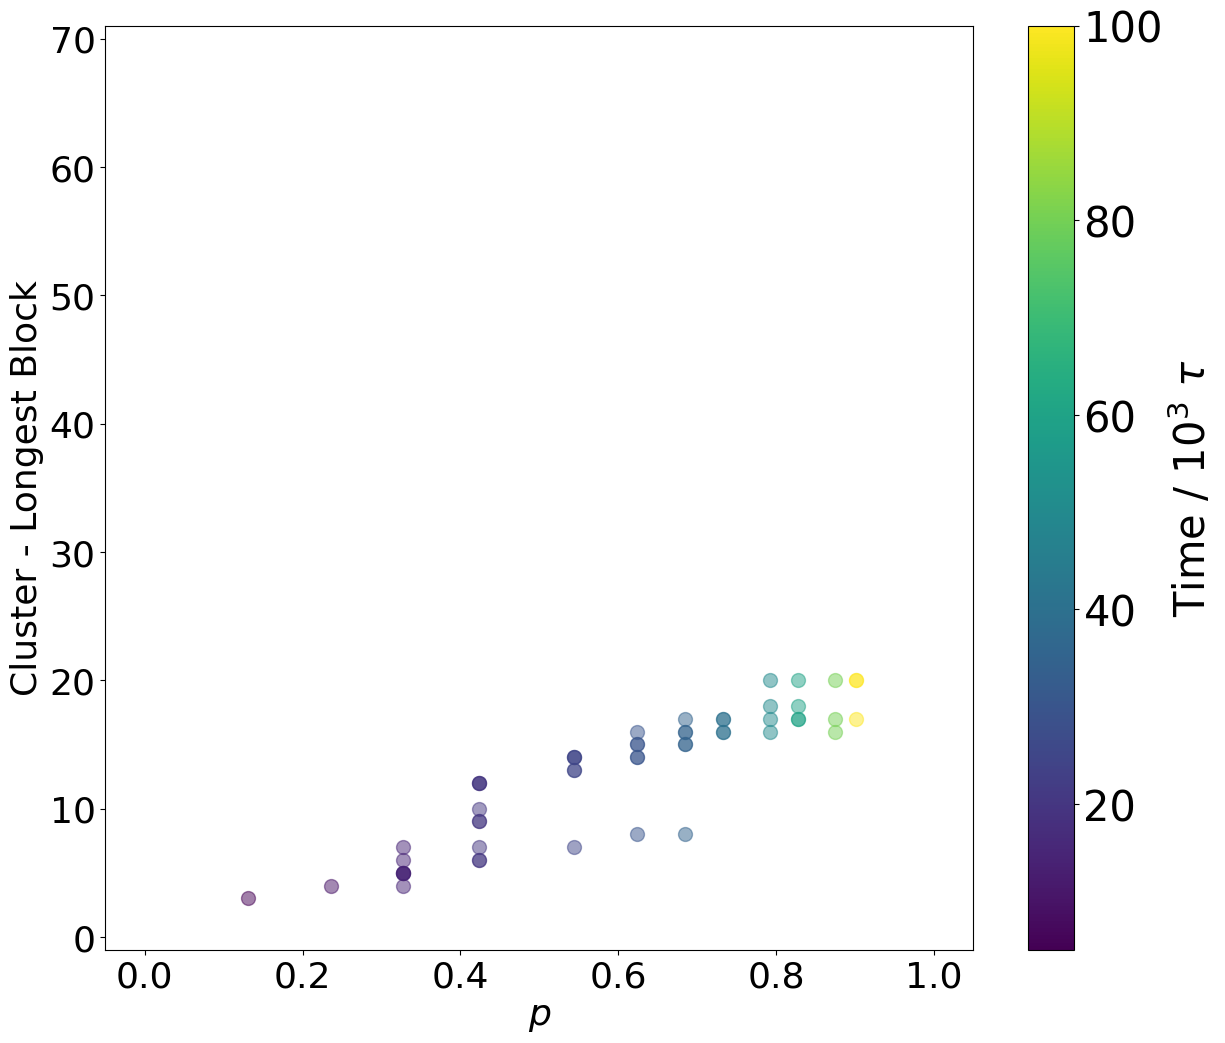

In [16]:
fig, host = plt.subplots(1,1,figsize = (14,12))

for time_index,snap_data in enumerate(all_snaps_data):
    for cluster_index,cluster_data in enumerate(snap_data):
        host.scatter(p_global[time_index],cluster_data[13],100,color=cmap(c_id[time_index]),marker='o',alpha=0.5)

        
host.tick_params(axis='both', which='major', labelsize=26)

cbar = plt.colorbar(sm,ax=host)#,label=r'$\frac{\tau_D}{\tau_R}$');
#cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(label=r"Time / $10^3 \ \tau$",size=30)
cbar.ax.tick_params(labelsize=30)
cbar.ax.yaxis.offsetText.set_fontsize(30)
#cbar.ax.set_yticklabels('')


host.set_xlabel(r"$p$",size=26)
host.set_ylabel(r"Cluster - Longest Block",size=26)
host.set_yticks([0,10,20,30,40,50,60,70]);
host.set_ylim(-1, 71);
host.set_xlim(-0.05, 1.05);

#host.legend(handles = [patch1,patch2,patch3],fontsize=26)

#fig.savefig('copoly3_cluster_dominant_species_fraction.png',dpi=300, bbox_inches='tight')

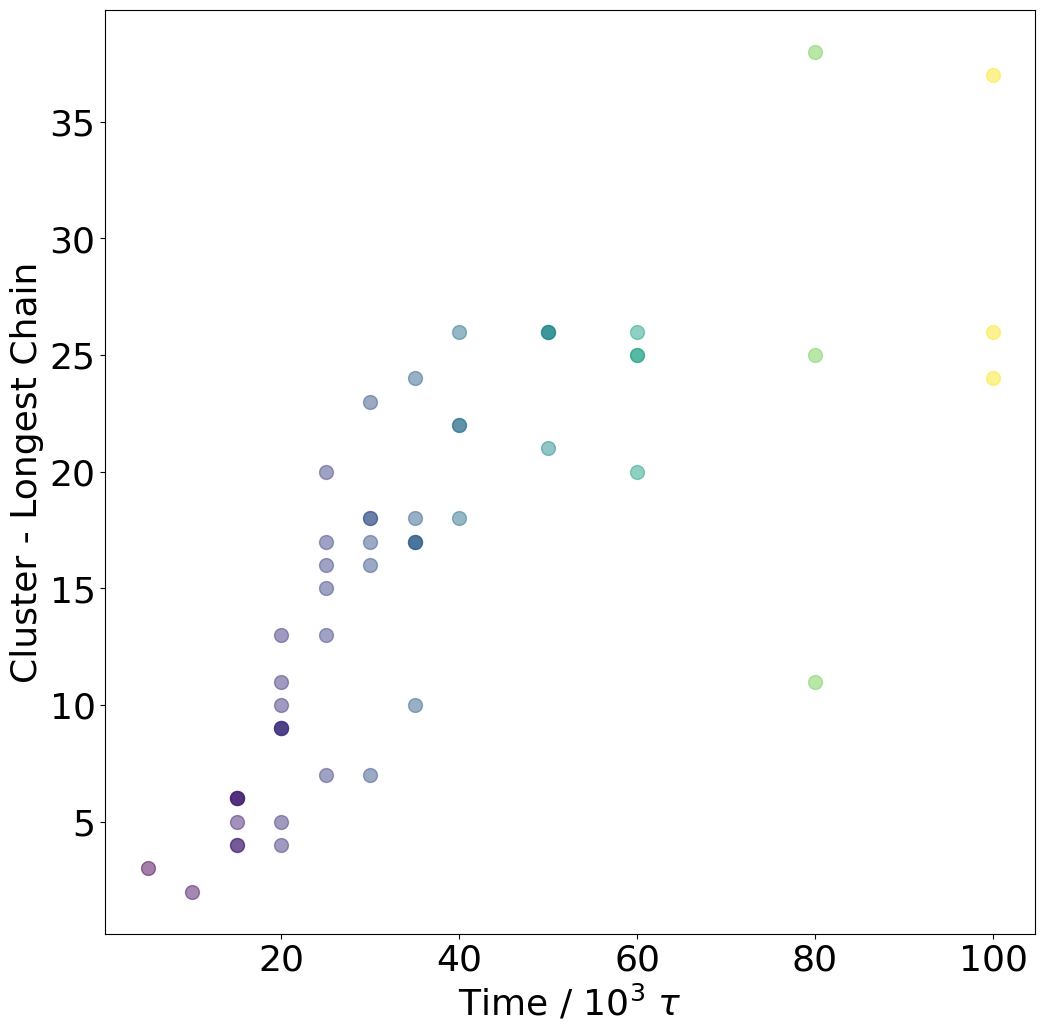

In [17]:
fig, host = plt.subplots(1,1,figsize = (12,12))

for time_index,snap_data in enumerate(all_snaps_data):
    for cluster_index,cluster_data in enumerate(snap_data):
        host.scatter((10**(-6))*steps_global[time_index],cluster_data[12],100,color=cmap(c_id[time_index]),marker='o',alpha=0.5)



host.tick_params(axis='both', which='major', labelsize=26)


host.set_xlabel(r"Time / $10^3 \ \tau$",size=26)
host.set_ylabel(r"Cluster - Longest Chain",size=26);
#host.set_ylim(-0.05, 1.05);
#host.set_xlim(-13.05, -7.05);

#host.legend(handles = [patch1,patch2,patch3],fontsize=26)

#fig.savefig('copoly3_cluster_dominant_species_fraction.png',dpi=300, bbox_inches='tight')

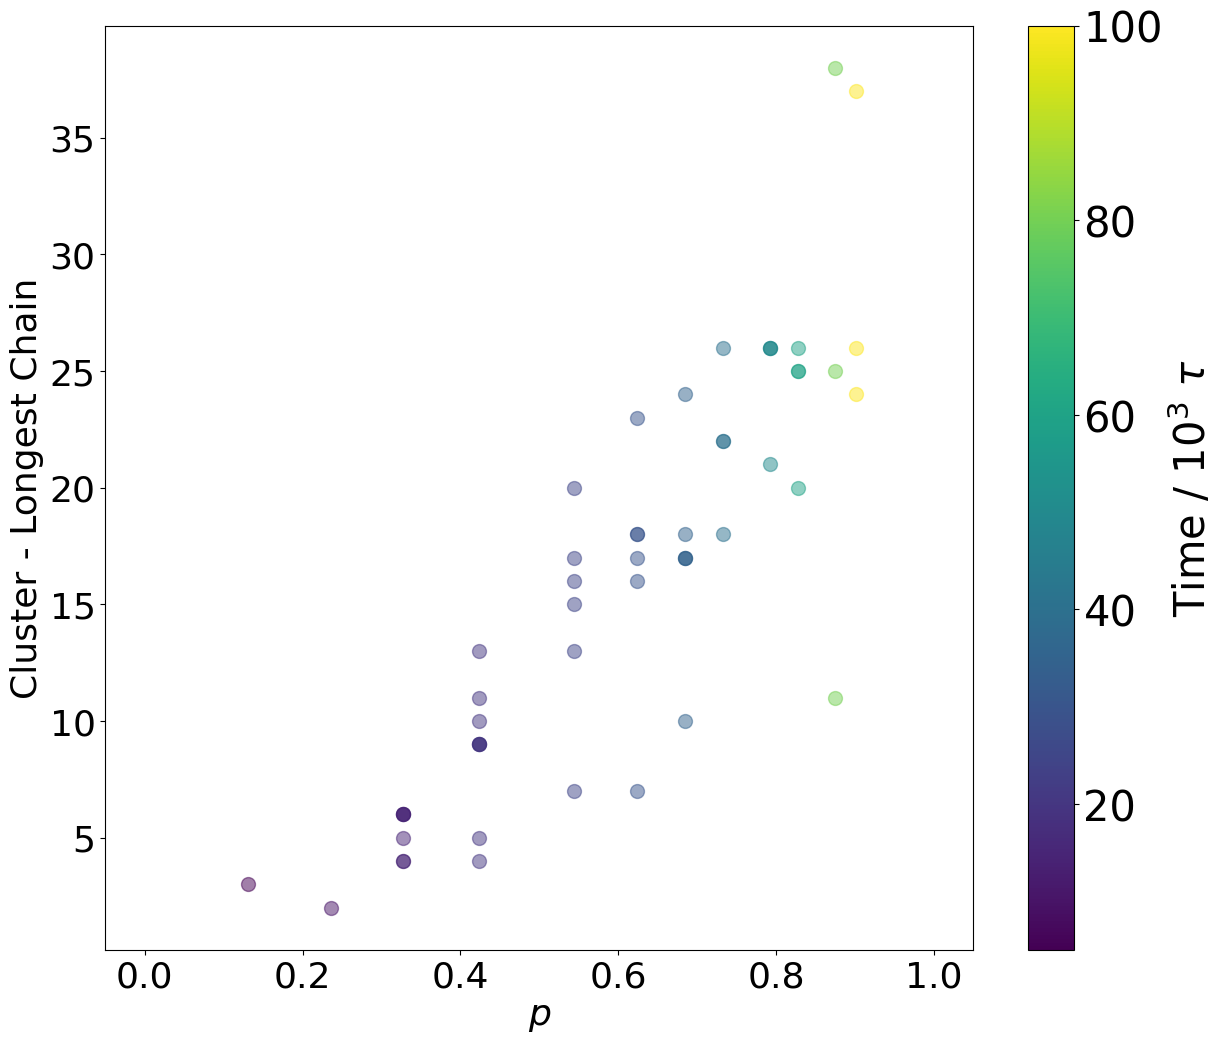

In [18]:
fig, host = plt.subplots(1,1,figsize = (14,12))

for time_index,snap_data in enumerate(all_snaps_data):
    for cluster_index,cluster_data in enumerate(snap_data):
        host.scatter(p_global[time_index],cluster_data[12],100,color=cmap(c_id[time_index]),marker='o',alpha=0.5)

        
host.tick_params(axis='both', which='major', labelsize=26)


host.set_xlabel(r"$p$",size=26)
host.set_ylabel(r"Cluster - Longest Chain",size=26)
#host.set_ylim(-0.05, 1.05);
host.set_xlim(-0.05, 1.05);

cbar = plt.colorbar(sm,ax=host)#,label=r'$\frac{\tau_D}{\tau_R}$');
#cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(label=r"Time / $10^3 \ \tau$",size=30)
cbar.ax.tick_params(labelsize=30)
cbar.ax.yaxis.offsetText.set_fontsize(30)
#cbar.ax.set_yticklabels('')



#host.legend(handles = [patch1,patch2,patch3],fontsize=26)

#fig.savefig('copoly3_cluster_dominant_species_fraction.png',dpi=300, bbox_inches='tight')

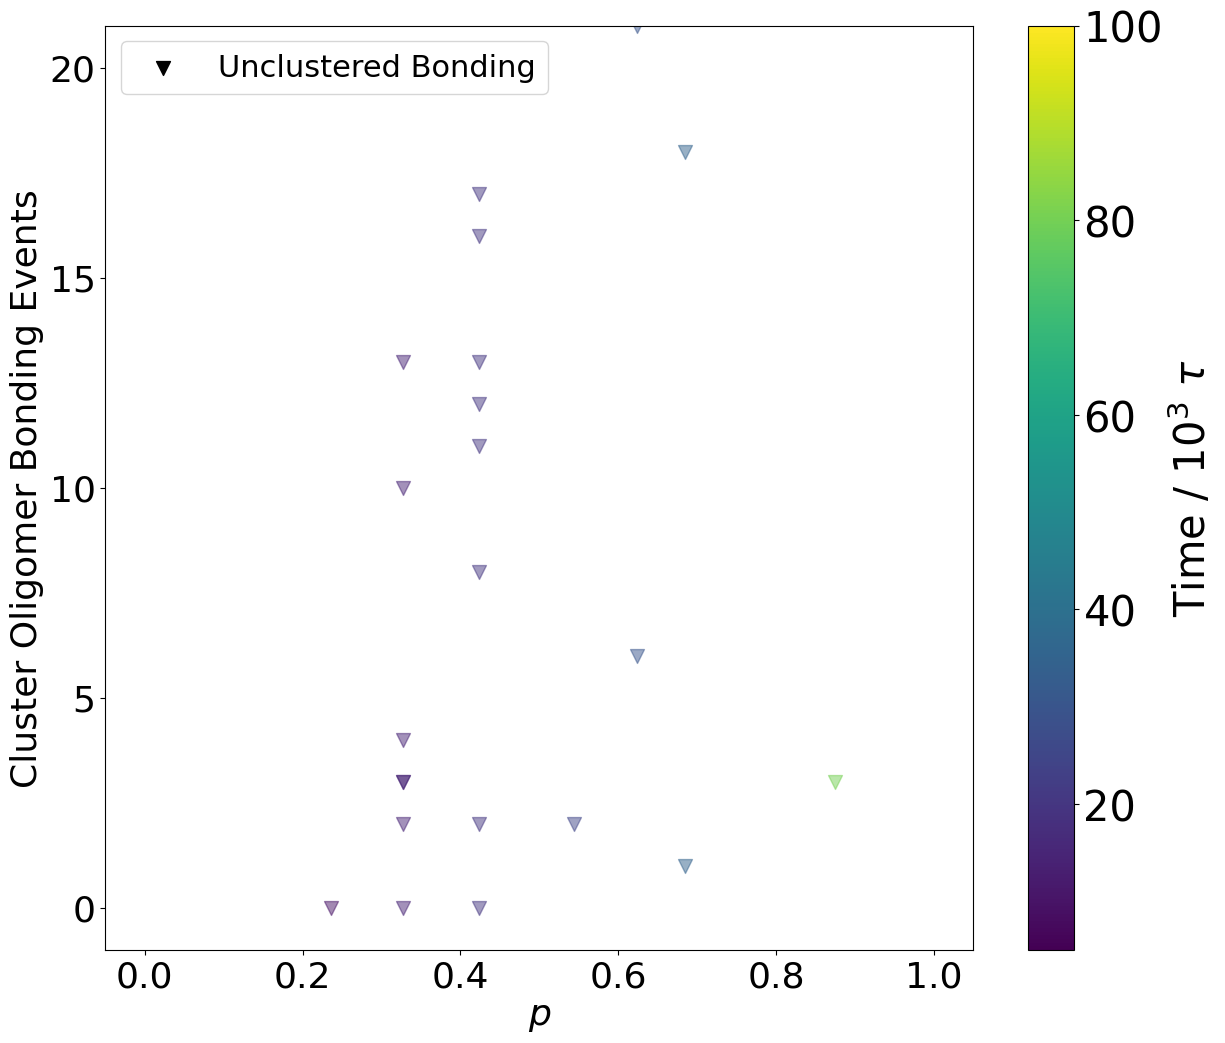

In [19]:
fig, host = plt.subplots(1,1,figsize = (14,12))

leg1=host.scatter([],[],100,color='k',marker='o',label='Self Bonding')
leg2=host.scatter([],[],100,color='k',marker='^',label='Merger Bonding')
leg3=host.scatter([],[],100,color='k',marker='v',label='Unclustered Bonding')

for time_index,snap_data in enumerate(all_snaps_data[:-1]):
    if time_index>0:
        for cluster_index,cluster_data in enumerate(snap_data):
            #host.scatter(p_global[time_index],np.sum(np.array([len(entry) for entry in cluster_data[-1][0]])),100,color=cmap(c_id[time_index]),marker='o',alpha=0.5)
            #host.scatter(p_global[time_index],np.sum(np.array([len(entry) for entry in cluster_data[-1][1]])),100,color=cmap(c_id[time_index]),marker='^',alpha=0.5)
            host.scatter(p_global[time_index],np.sum(np.array([len(entry) for entry in cluster_data[-1][2]])),100,color=cmap(c_id[time_index]),marker='v',alpha=0.5)


host.tick_params(axis='both', which='major', labelsize=26)


host.set_xlabel(r"$p$",size=26)
host.set_ylabel(r"Cluster Oligomer Bonding Events",size=26)
#host.set_ylim(-0.1, 80.1);
#host.set_yticks([0,20,40,60,80])
host.set_xlim(-0.05, 1.05);





cbar = plt.colorbar(sm,ax=host)#,label=r'$\frac{\tau_D}{\tau_R}$');
#cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(label=r"Time / $10^3 \ \tau$",size=30)
cbar.ax.tick_params(labelsize=30)
cbar.ax.yaxis.offsetText.set_fontsize(30)
#cbar.ax.set_yticklabels('')




# host.set_ylim(-1, 81);
# host.set_yticks([0,20,40,60,80])
# host.legend(handles = [leg1],fontsize=22,loc='upper left');

# host.set_ylim(-1, 21);
# host.set_yticks([0,5,10,15,20])
# host.legend(handles = [leg2],fontsize=22,loc='upper left');

host.set_ylim(-1, 21);
host.set_yticks([0,5,10,15,20])
host.legend(handles = [leg3],fontsize=22,loc='upper left');

# host.set_ylim(-1, 81);
# host.set_yticks([0,20,40,60,80])
# host.legend(handles = [leg1,leg2,leg3],fontsize=22,loc='upper left');

#fig.savefig('copoly3_cluster_dominant_species_fraction.png',dpi=300, bbox_inches='tight')

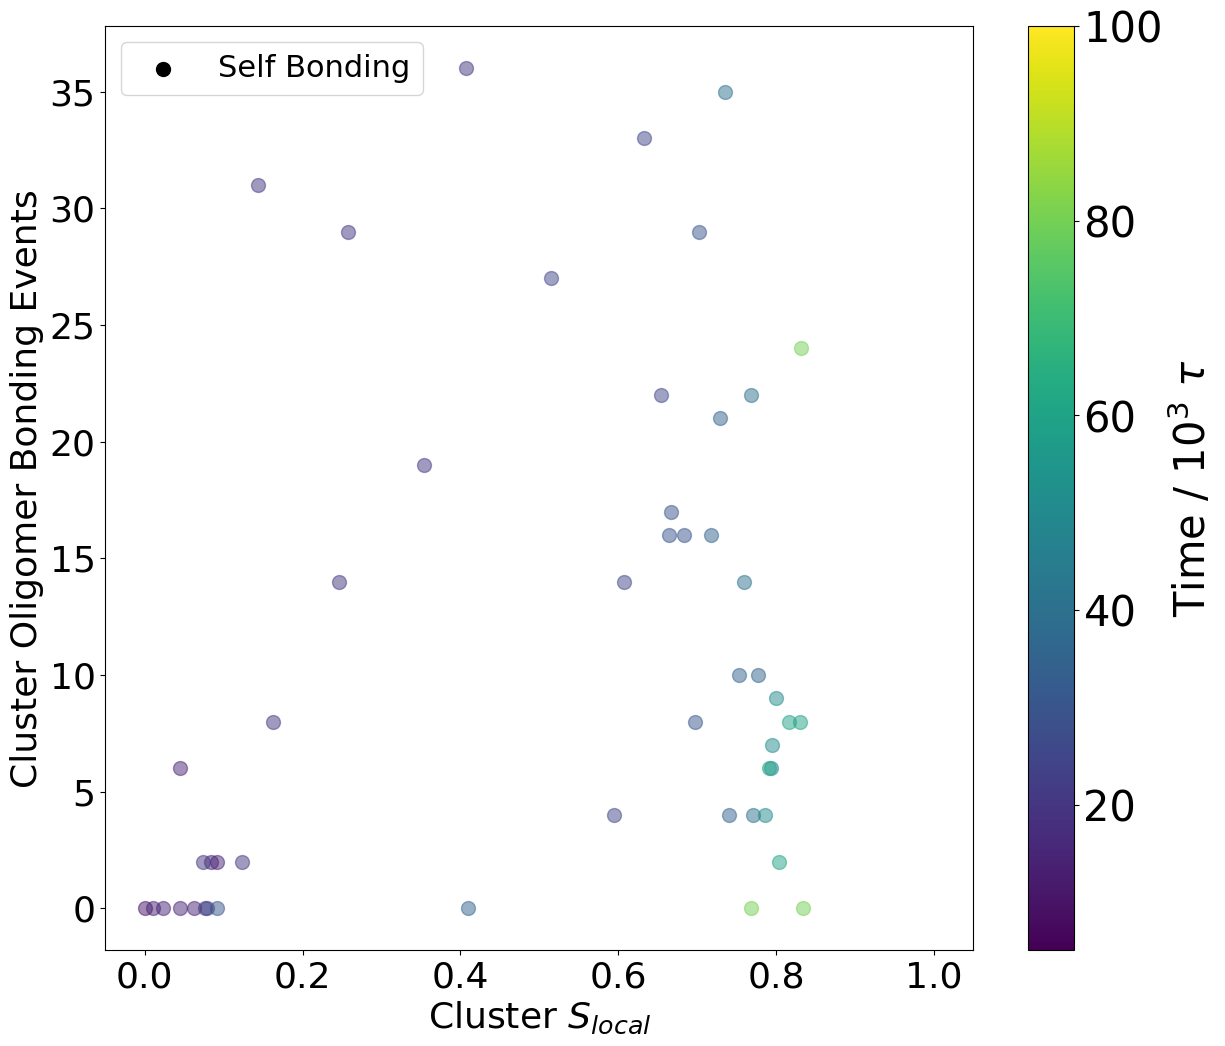

In [20]:
fig, host = plt.subplots(1,1,figsize = (14,12))

leg1=host.scatter([],[],100,color='k',marker='o',label='Self Bonding')
leg2=host.scatter([],[],100,color='k',marker='^',label='Merger Bonding')
leg3=host.scatter([],[],100,color='k',marker='v',label='Unclustered Bonding')

for time_index,snap_data in enumerate(all_snaps_data[:-1]):
    if time_index>0:
        for cluster_index,cluster_data in enumerate(snap_data):
            host.scatter(cluster_data[19],np.sum(np.array([len(entry) for entry in cluster_data[-1][0]])),100,color=cmap(c_id[time_index]),marker='o',alpha=0.5)
            #host.scatter(cluster_data[19],np.sum(np.array([len(entry) for entry in cluster_data[-1][1]])),100,color=cmap(c_id[time_index]),marker='^',alpha=0.5)
            #host.scatter(cluster_data[19],np.sum(np.array([len(entry) for entry in cluster_data[-1][2]])),100,color=cmap(c_id[time_index]),marker='v',alpha=0.5)
#             if cluster_data[19] < 0.2:
#                 print('Time:',steps_global[time_index])
#                 print('Cluster:',cluster_index+1)

host.tick_params(axis='both', which='major', labelsize=26)


host.set_xlabel(r"Cluster $S_{local}$",size=26)
host.set_ylabel(r"Cluster Oligomer Bonding Events",size=26)
#host.set_ylim(-0.05, 1.05);
host.set_xlim(-0.05, 1.05);


cbar = plt.colorbar(sm,ax=host)#,label=r'$\frac{\tau_D}{\tau_R}$');
#cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(label=r"Time / $10^3 \ \tau$",size=30)
cbar.ax.tick_params(labelsize=30)
cbar.ax.yaxis.offsetText.set_fontsize(30)
#cbar.ax.set_yticklabels('')

host.legend(handles = [leg1],fontsize=22,loc='upper left');
#host.legend(handles = [leg2],fontsize=22,loc='upper left');
#host.legend(handles = [leg3],fontsize=22,loc='upper left');
#host.legend(handles = [leg1,leg2,leg3],fontsize=22,loc='upper left');

#fig.savefig('copoly3_cluster_dominant_species_fraction.png',dpi=300, bbox_inches='tight')

/tmp/ipykernel_20464/927060256.py:10: RuntimeWarning: invalid value encountered in scalar divide
  host.scatter(cluster_data[19],np.sum(np.array([len(entry) for entry in cluster_data[-1][0]]))/np.sum(np.array([len(entry) for entry in cluster_data[-1][3]])),100,color=cmap(c_id[time_index]),marker='o',alpha=0.5)


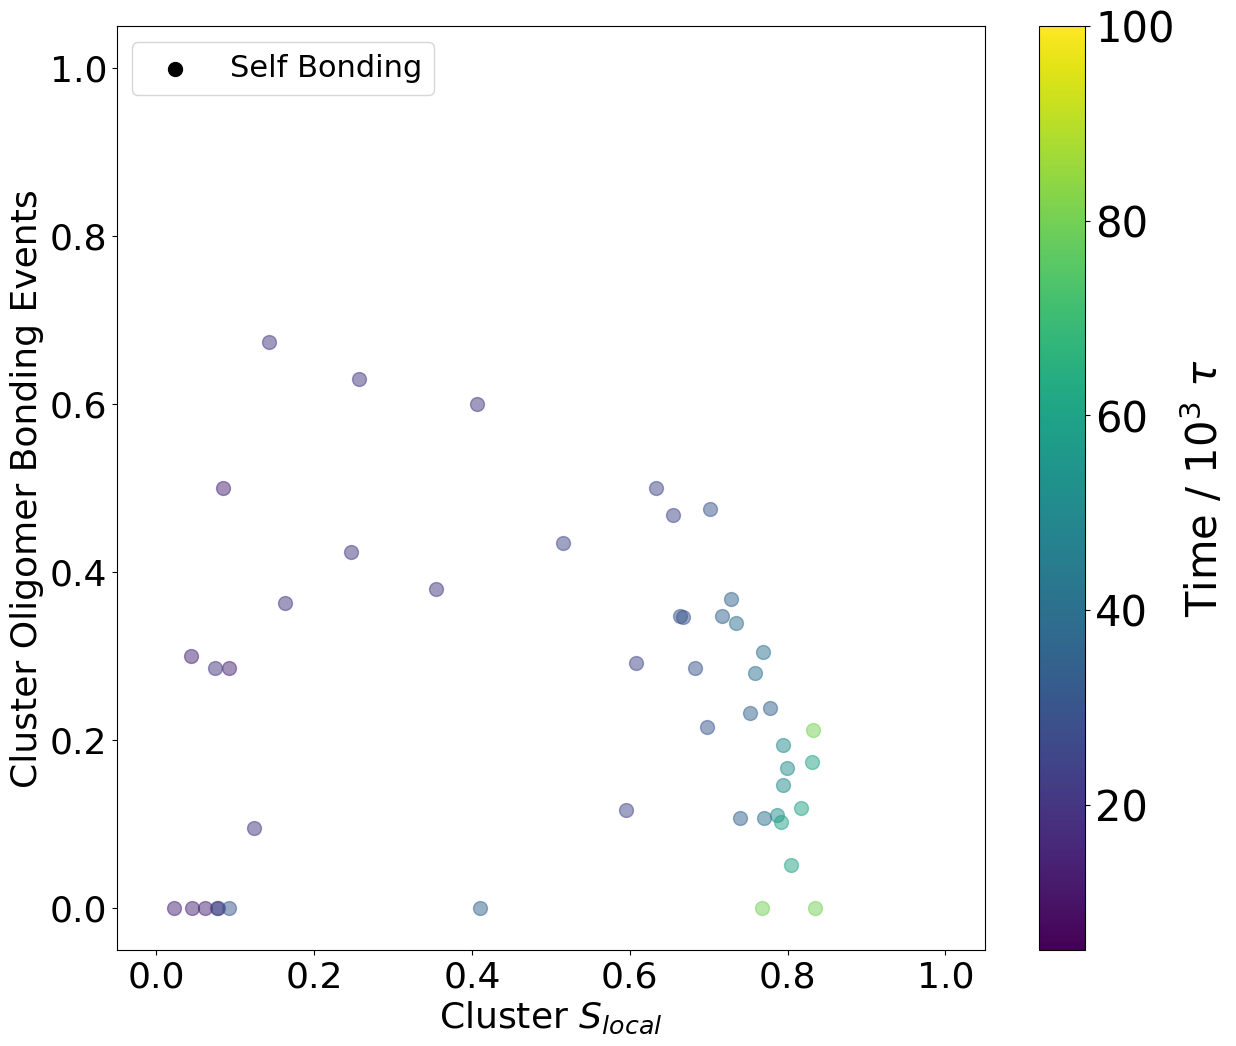

In [21]:
fig, host = plt.subplots(1,1,figsize = (14,12))

leg1=host.scatter([],[],100,color='k',marker='o',label='Self Bonding')
leg2=host.scatter([],[],100,color='k',marker='^',label='Merger Bonding')
leg3=host.scatter([],[],100,color='k',marker='v',label='Unclustered Bonding')

for time_index,snap_data in enumerate(all_snaps_data[:-1]):
    if time_index>0:
        for cluster_index,cluster_data in enumerate(snap_data):
            host.scatter(cluster_data[19],np.sum(np.array([len(entry) for entry in cluster_data[-1][0]]))/np.sum(np.array([len(entry) for entry in cluster_data[-1][3]])),100,color=cmap(c_id[time_index]),marker='o',alpha=0.5)
            #host.scatter(cluster_data[19],np.sum(np.array([len(entry) for entry in cluster_data[-1][1]])),100,color=cmap(c_id[time_index]),marker='^',alpha=0.5)
            #host.scatter(cluster_data[19],np.sum(np.array([len(entry) for entry in cluster_data[-1][2]])),100,color=cmap(c_id[time_index]),marker='v',alpha=0.5)
#             if cluster_data[19] < 0.2:
#                 print('Time:',steps_global[time_index])
#                 print('Cluster:',cluster_index+1)

host.tick_params(axis='both', which='major', labelsize=26)


host.set_xlabel(r"Cluster $S_{local}$",size=26)
host.set_ylabel(r"Cluster Oligomer Bonding Events",size=26)
host.set_ylim(-0.05, 1.05);
host.set_xlim(-0.05, 1.05);


cbar = plt.colorbar(sm,ax=host)#,label=r'$\frac{\tau_D}{\tau_R}$');
#cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(label=r"Time / $10^3 \ \tau$",size=30)
cbar.ax.tick_params(labelsize=30)
cbar.ax.yaxis.offsetText.set_fontsize(30)
#cbar.ax.set_yticklabels('')

host.legend(handles = [leg1],fontsize=22,loc='upper left');
#host.legend(handles = [leg2],fontsize=22,loc='upper left');
#host.legend(handles = [leg3],fontsize=22,loc='upper left');
#host.legend(handles = [leg1,leg2,leg3],fontsize=22,loc='upper left');

#fig.savefig('copoly3_cluster_dominant_species_fraction.png',dpi=300, bbox_inches='tight')

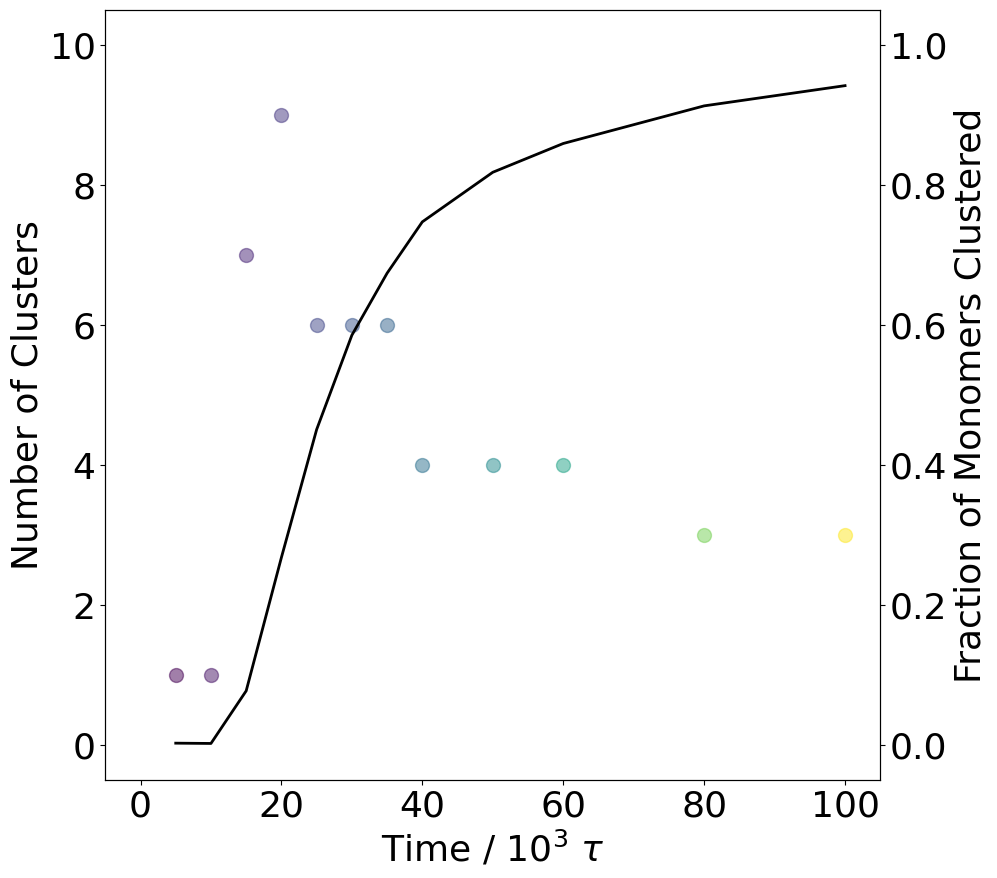

In [22]:
fig, host = plt.subplots(1,1,figsize = (10,10))
par = host.twinx()

frac_clustered = []
for time_index,snap_data in enumerate(all_snaps_data):
    clustered_num = 0
    for cluster_index,cluster_data in enumerate(snap_data):
        clustered_num+=(all_snaps[time_index][cluster_index].params['numA'] + all_snaps[time_index][cluster_index].params['numB']) 
    host.scatter((10**(-6))*steps_global[time_index],len(snap_data),100,color=cmap(c_id[time_index]),marker='o',alpha=0.5)
    frac_clustered.append(clustered_num/7200)
    
par.plot((10**(-6))*np.array(steps_global),np.array(frac_clustered),'-k',linewidth=2.)

par.set_ylim((-0.05,1.05)) 
host.set_ylim((-0.5,10.5))
host.set_xlim((-5,105))
    
host.tick_params(axis='both', which='major', labelsize=26)
par.tick_params(axis='both', which='major', labelsize=26)
host.set_xlabel(r"Time / $10^3 \ \tau$",size=26)
host.set_ylabel("Number of Clusters",size=26)
par.set_ylabel("Fraction of Monomers Clustered",size=26);

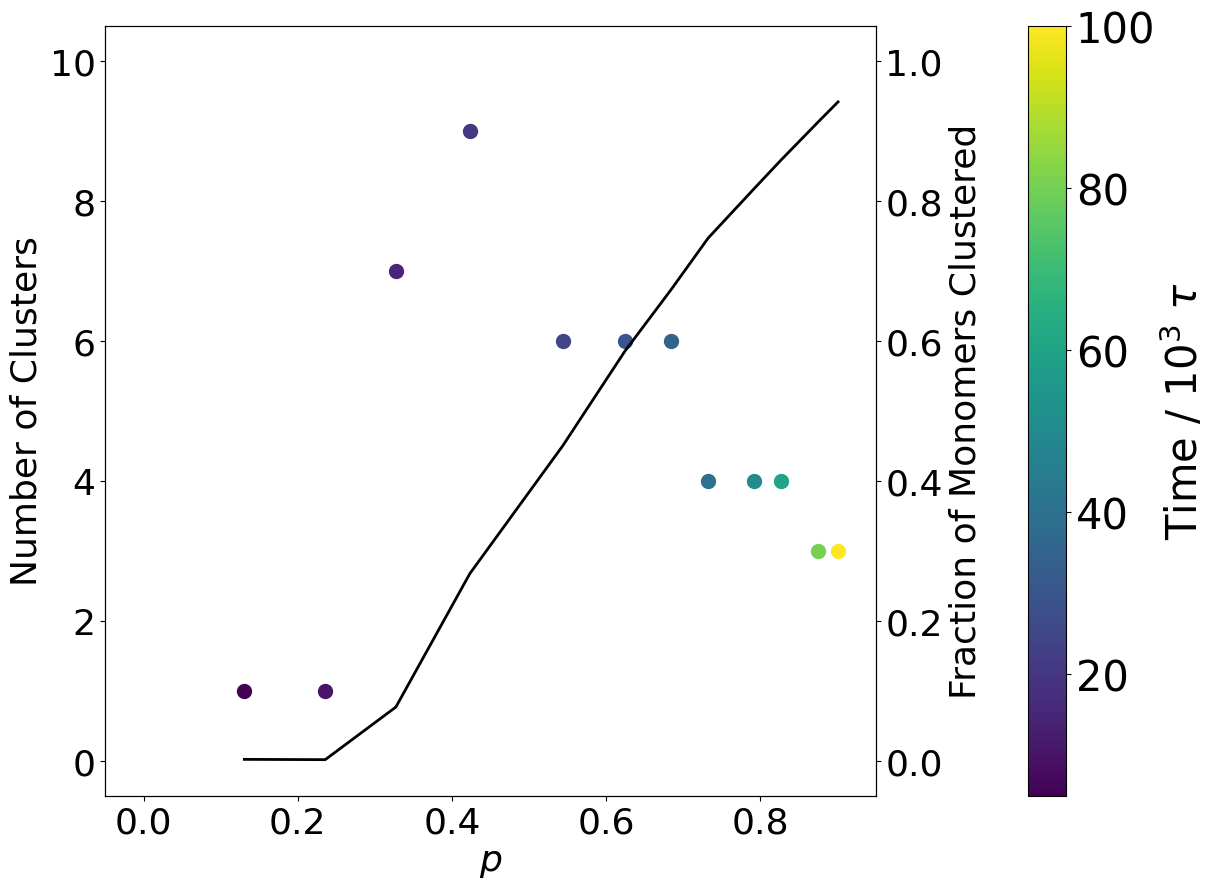

In [23]:
fig, host = plt.subplots(1,1,figsize = (14,10))
par = host.twinx()

frac_clustered = []
for time_index,snap_data in enumerate(all_snaps_data):
    clustered_num = 0
    for cluster_index,cluster_data in enumerate(snap_data):
        clustered_num+=(all_snaps[time_index][cluster_index].params['numA'] + all_snaps[time_index][cluster_index].params['numB']) 
    host.scatter(p_global[time_index],len(snap_data),100,color=cmap(c_id[time_index]),marker='o')
    frac_clustered.append(clustered_num/7200)
    
par.plot(np.array(p_global),np.array(frac_clustered),'-k',linewidth=2.)
par.set_ylim((-0.05,1.05)) 
host.set_ylim((-0.5,10.5))
host.set_xlim((-0.05,0.95))
    
cbar = plt.colorbar(sm,ax=host,pad=0.14)#,label=r'$\frac{\tau_D}{\tau_R}$');
#cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(label=r"Time / $10^3 \ \tau$",size=30)
cbar.ax.tick_params(labelsize=30)
cbar.ax.yaxis.offsetText.set_fontsize(30)
#cbar.ax.set_yticklabels('')
    
    
host.tick_params(axis='both', which='major', labelsize=26)
par.tick_params(axis='both', which='major', labelsize=26)
host.set_xlabel(r"$p$",size=26)
host.set_ylabel("Number of Clusters",size=26)
par.set_ylabel("Fraction of Monomers Clustered",size=26);



In [24]:
# fig, host = plt.subplots(1,1,figsize = (10,10))

# for time_index,snap_data in enumerate(all_snaps_data):
#     host.scatter([-1],[-1],100,color=cmap(c_id[time_index]),marker='o', label=str(int(steps_global[time_index]/1000000)))
    
# host.set_ylim((-0.5,10.5))
# host.set_xlim((-0.05,0.95))
# legend = host.legend(fontsize=22)

# legend.set_title(r'Time / $10^3 \ \tau$')
# legend.get_title().set_fontsize('22') 
# fig.savefig('clustering_legend.png',dpi=600, bbox_inches='tight')

In [25]:
cluster_y_unclustered_frac = []
cluster_y_unclustered_count = []
cluster_y_merger_frac = []
cluster_y_merger_count = []
cluster_y_self_frac = []
cluster_y_self_count = []

for time_index,snap_data in enumerate(all_snaps_data[:-1]):
    if time_index>0:
        merger_frac = []
        merger_count = []
        unclustered_frac = []
        unclustered_count = []
        self_frac = []
        self_count = []
        for cluster_index,cluster_data in enumerate(snap_data):
            self_frac.append(np.sum(np.array([len(entry) for entry in cluster_data[-1][0]]))/np.sum(np.array([len(entry) for entry in cluster_data[-1][3]])))
            merger_frac.append(np.sum(np.array([len(entry) for entry in cluster_data[-1][1]]))/np.sum(np.array([len(entry) for entry in cluster_data[-1][3]])))
            unclustered_frac.append(np.sum(np.array([len(entry) for entry in cluster_data[-1][2]]))/np.sum(np.array([len(entry) for entry in cluster_data[-1][3]])))
            self_count.append(np.sum(np.array([len(entry) for entry in cluster_data[-1][0]])))
            merger_count.append(np.sum(np.array([len(entry) for entry in cluster_data[-1][1]])))
            unclustered_count.append(np.sum(np.array([len(entry) for entry in cluster_data[-1][2]])))
            
        cluster_y_merger_frac.append(merger_frac)
        cluster_y_merger_count.append(merger_count)
        cluster_y_unclustered_frac.append(unclustered_frac)
        cluster_y_unclustered_count.append(unclustered_count)
        cluster_y_self_frac.append(self_frac)
        cluster_y_self_count.append(self_count)


/tmp/ipykernel_20464/97839038.py:17: RuntimeWarning: invalid value encountered in scalar divide
  self_frac.append(np.sum(np.array([len(entry) for entry in cluster_data[-1][0]]))/np.sum(np.array([len(entry) for entry in cluster_data[-1][3]])))
/tmp/ipykernel_20464/97839038.py:18: RuntimeWarning: invalid value encountered in scalar divide
  merger_frac.append(np.sum(np.array([len(entry) for entry in cluster_data[-1][1]]))/np.sum(np.array([len(entry) for entry in cluster_data[-1][3]])))
/tmp/ipykernel_20464/97839038.py:19: RuntimeWarning: invalid value encountered in scalar divide
  unclustered_frac.append(np.sum(np.array([len(entry) for entry in cluster_data[-1][2]]))/np.sum(np.array([len(entry) for entry in cluster_data[-1][3]])))


In [26]:
#Saving results
stiff_cluster_bonding = [
cluster_y_unclustered_count,
cluster_y_merger_count,
cluster_y_self_count,
cluster_y_unclustered_frac,
cluster_y_merger_frac,
cluster_y_self_frac]
with open('./stiff_cluster_bonding.pickle','wb') as f1:
    pickle.dump(stiff_cluster_bonding,f1)
    
with open('./stiff_cluster_snaps_data.pickle','wb') as f1:
    pickle.dump(all_snaps_data,f1)
    
with open('./stiff_cluster_snaps.pickle','wb') as f1:
    pickle.dump(all_snaps,f1)
    
    
    
with open('./stiff_unclustered_data.pickle','wb') as f1:
    pickle.dump(all_unclustered_data,f1)
    
with open('./stiff_unclustered.pickle','wb') as f1:
    pickle.dump(all_unclustered,f1)
    

    
with open('./stiff_int_ext_ends.pickle','wb') as f:
    pickle.dump(all_int_ext_ends,f)

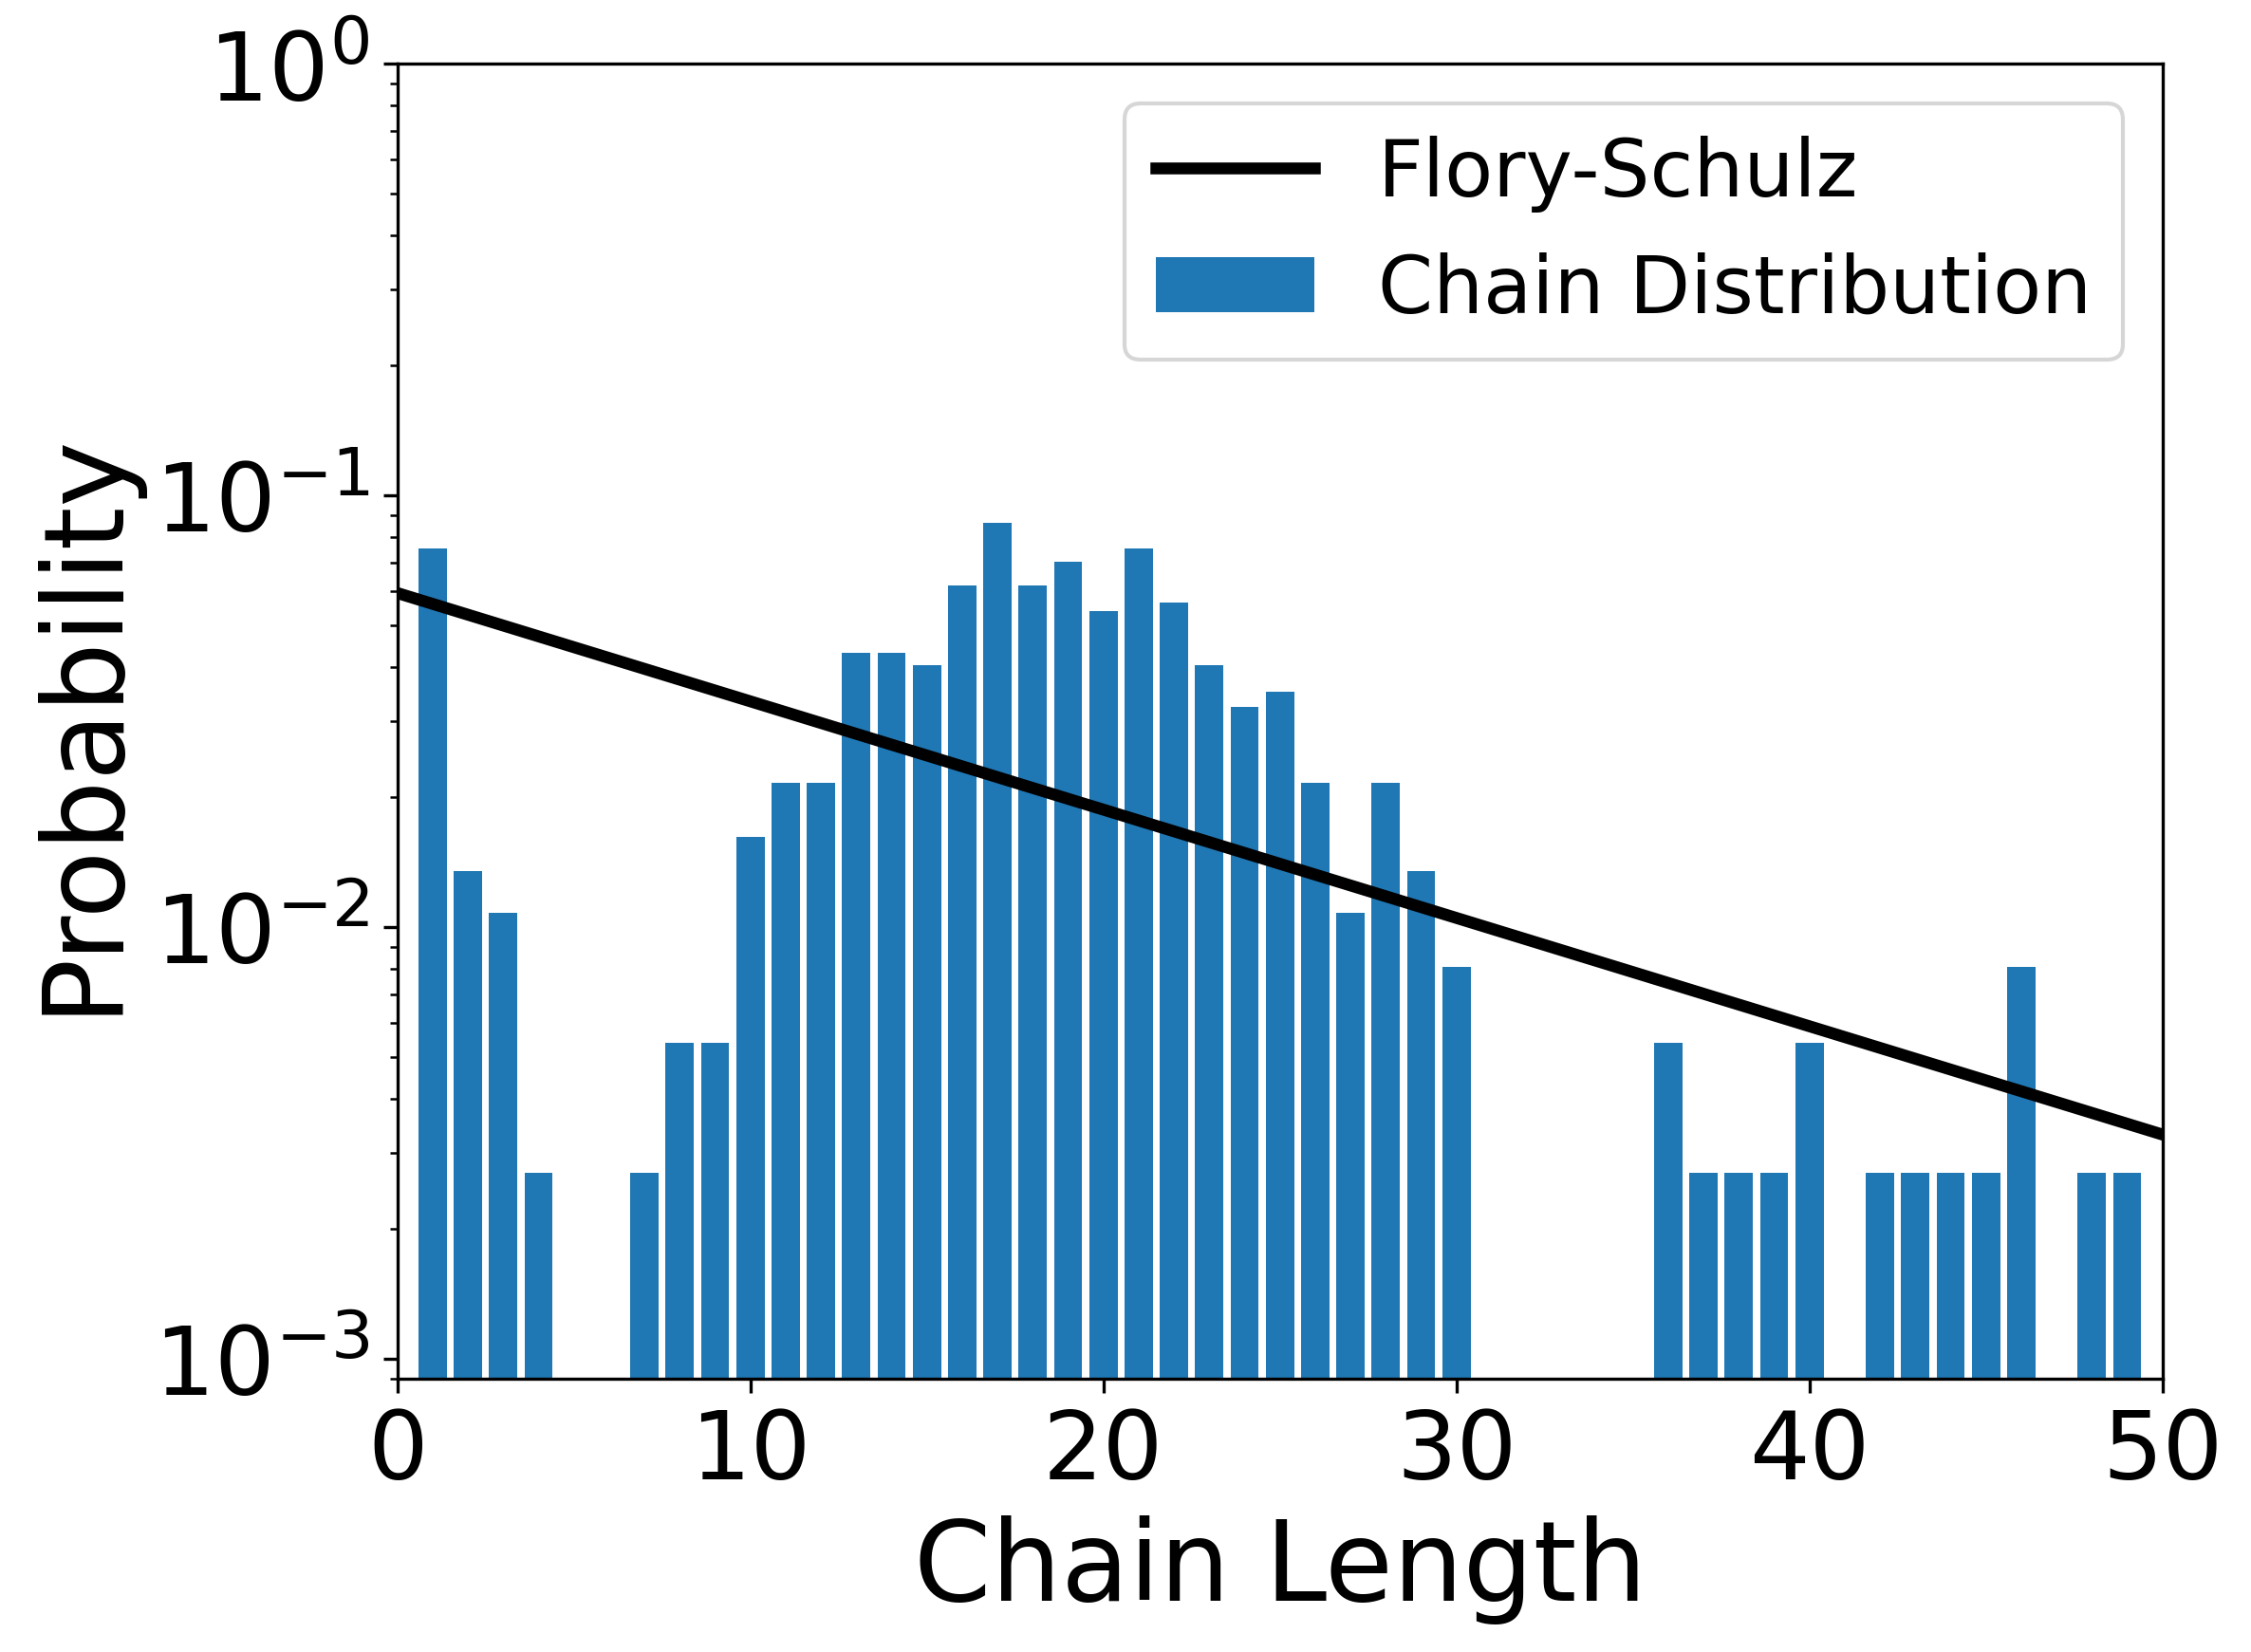

In [27]:
time_index = -1
all_chain = np.zeros(351)
all_p = 0
for cluster_index,cluster_data in enumerate(all_snaps_data[time_index]):
    all_p += cluster_data[3][0]
    for i,val in enumerate(cluster_data[4][0]):
        all_chain[val] += cluster_data[4][1][i]
        
all_p /= len(all_snaps_data[time_index])

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
matplotlib.rcParams['figure.dpi'] = 300

lw = 3.


x_chain = np.linspace(0,350,351)
#x_chain_FS = np.linspace(0,50,51)
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(x_chain, ((1-all_p)*all_p**(x_chain-1)),'-k',linewidth=lw)
ax.bar(x_chain,all_chain/np.sum(all_chain),align='center')

ax.set_xlabel('Chain Length')
ax.set_ylabel('Probability')
ax.set_xlim((0,50))
ax.set_yscale('log')
ax.set_ylim((9e-4,1));
#ax.text(30,0.2,label)
ax.legend(('Flory-Schulz','Chain Distribution'));
#fig.savefig('copoly3_standard_chain.png',dpi=300, bbox_inches='tight')

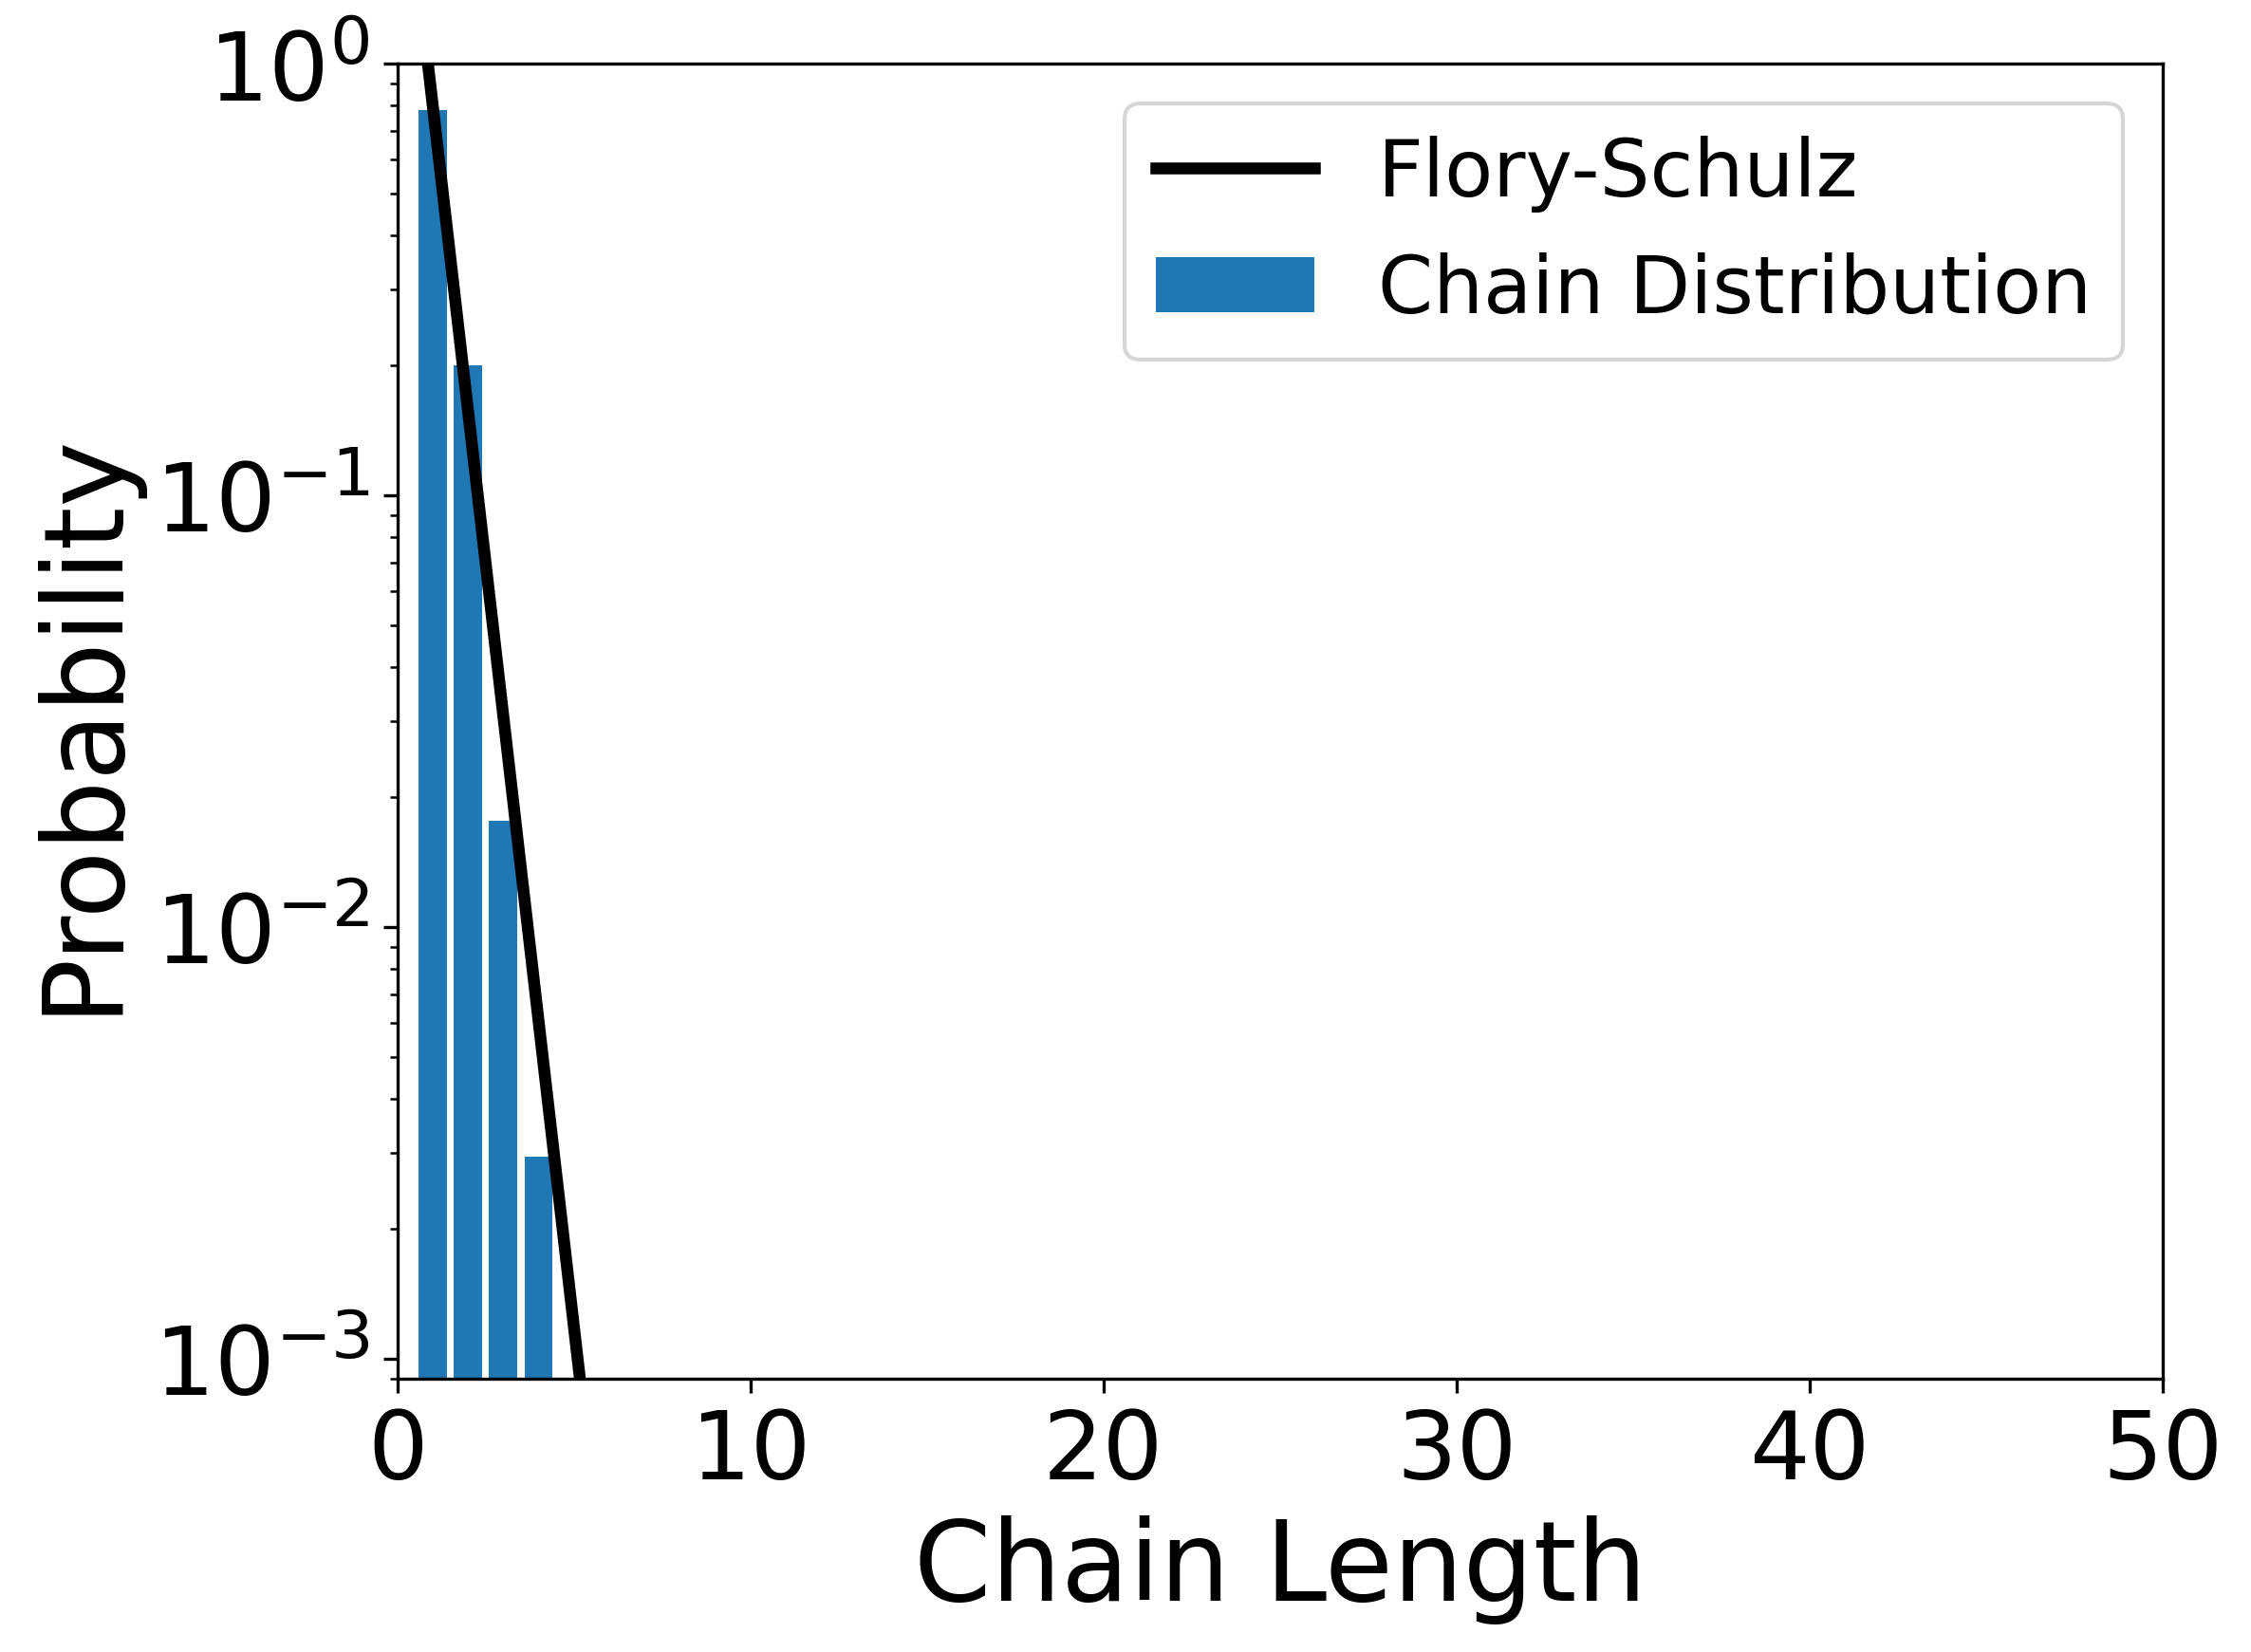

In [28]:
time_index = -1
unclustered_chain = np.zeros(351)
for cluster_index,cluster_data in enumerate(all_unclustered_data[time_index]):
    unclustered_p = cluster_data[3][0]
    for i,val in enumerate(cluster_data[4][0]):
        unclustered_chain[val] += cluster_data[4][1][i]
        


SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
matplotlib.rcParams['figure.dpi'] = 300

lw = 3.


x_chain = np.linspace(0,350,351)
#x_chain_FS = np.linspace(0,50,51)
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(x_chain, ((1-unclustered_p)*unclustered_p**(x_chain-1)),'-k',linewidth=lw)
ax.bar(x_chain,unclustered_chain/np.sum(unclustered_chain),align='center')

ax.set_xlabel('Chain Length')
ax.set_ylabel('Probability')
ax.set_xlim((0,50))
ax.set_yscale('log')
ax.set_ylim((9e-4,1));
#ax.text(30,0.2,label)
ax.legend(('Flory-Schulz','Chain Distribution'));
#fig.savefig('copoly3_standard_chain.png',dpi=300, bbox_inches='tight')